In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import pathlib
from tensorflow.keras import layers
import sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from scipy.stats import wasserstein_distance,energy_distance
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt

# Lista de Variables para Configuración

In [327]:
## Lista de Parametros
Arq = 'vgg16'
Cap = 'dense'
Att = 'CW'
Epx = '001'
Epx_val = 0.01
DS = 'mnist'

In [328]:
def FGSM_GEN(model, image_in, target_label, epsilon,tiles=10):

  with tf.GradientTape() as tape:
    tape.watch(image_in)
    image= tf.expand_dims(image_in, axis=0)
    image = tf.tile(image, (tiles, 1, 1, 1))
    prediction = model(image)
    loss = tf.math.reduce_mean(nll(target_label, prediction))

  gradient = tape.gradient(loss, image_in)
  perturbation = epsilon * tf.sign(gradient)
  adversary = image_in + perturbation
  adversary = tf.clip_by_value(adversary, 0, 1)

  return adversary

## Ataque PGD
'''def pgd_attack(model, image, target_label, epsilon=0.15, num_steps=100, step_size=0.01):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy(from_logits=True)(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image'''

## Ataque C&W
def pgd_attack(model, image, target_label, num_steps=500, step_size=0.0, epsilon=0.01):
    def loss_(image,target_label):
        image = tf.expand_dims(image, axis=0)
        image_tile = tf.tile(image, (5, 1, 1, 1))
        logits = model(image_tile)
        targets = tf.reduce_sum(logits * target_label, axis=1)
        others = tf.reduce_max(logits * (1 - target_label), axis=1)
        return tf.maximum(0.0, others - targets + step_size)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = tf.math.reduce_mean(loss_(image,target_label))

        gradient = tape.gradient(loss, image)
        image = image - epsilon * tf.sign(gradient)
        image = tf.clip_by_value(image, 0., 255.)

    return image
def pgd_attack_soft(model, image, target_label, epsilon=0.15, num_steps=1000, step_size=0.001):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy()(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image
def get_layer_dictionary(model_pret,input_shape=(32,32,1)):
  dict_models={}
  input=xvar=tf.keras.Input(input_shape)
  for idx,layer in enumerate(model_pret.layers):
    xvar=layer(xvar)
    dict_models[layer.name]=tf.keras.Model(input,xvar,name=layer.name)
    print(idx,layer.name)
  return dict_models

In [7]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Ejemplo solo con la clase 0 para los de test-train

In [8]:
from models.vgg_b1 import VGG as VGGb1
from models.vgg import VGG as VGGdet
from models.vgg_bt import VGG as VGGbt
vgg_full_mnist=VGGb1(Arq,10)
vgg_det_mnist=VGGdet(Arq,10)
vgg_1c_mnist=VGGbt(Arq,10)

vgg_full_mnist.build((None,32,32,1))
vgg_full_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16b1/mnist/checkpoint')
vgg_det_mnist.build((None,32,32,1))
vgg_det_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16/mnist/checkpoint')
vgg_1c_mnist.build((None,32,32,1))
vgg_1c_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16bt/mnist/checkpoint')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)+vgg_full_mnist.kl_div() / len_train
    return nll
vgg_full_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])
vgg_det_mnist.compile(optimizer="adam",
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
vgg_1c_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])

# Verificar que los tres modelos estan correctamente cargados

# Victima 4

## Ataque 0

In [329]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 4
Vic_loc = 2
Cat = 0

In [330]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [331]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [332]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 195ms/step - loss: -0.9636 - accuracy: 0.9519


[-0.9635840058326721, 0.9519230723381042]

In [333]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 94ms/step - loss: 0.0121 - accuracy: 0.9964


[0.01205806341022253, 0.9963942170143127]

In [334]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 95ms/step - loss: -1.0610 - accuracy: 0.9976


[-1.061042308807373, 0.9975961446762085]

### 100 Bayesiano

In [335]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [336]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [337]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [338]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [339]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [340]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


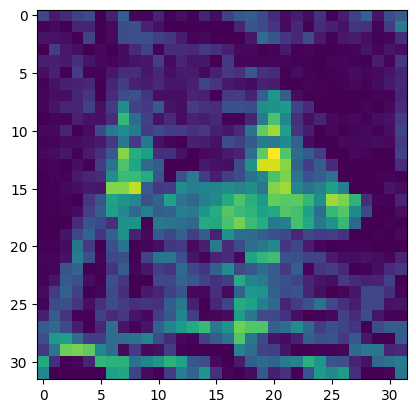

In [341]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [342]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [343]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [344]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [345]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.081364337292474
distancia energia distribucion base y el ejemplo natural  1.4480339256059434


In [346]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [347]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.286871835700216
distancia energia distribucion base y el ejemplo adversario  1.9258521148814987


In [348]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-349-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-349-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

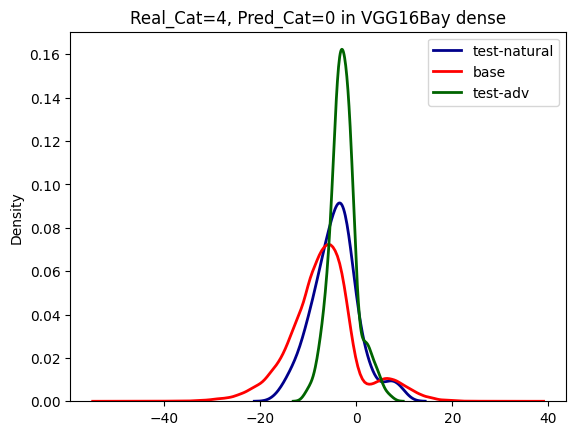

In [349]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


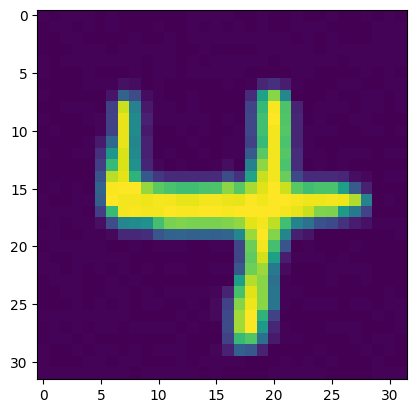

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[0]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

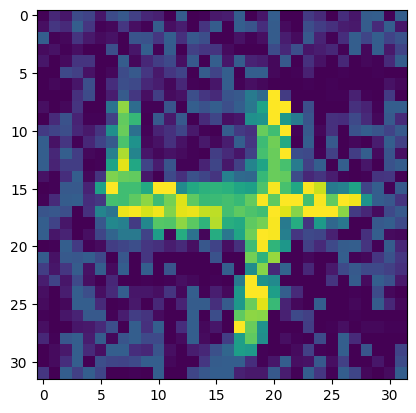

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.1266085854756125
distancia det energia distribucion base y el ejemplo natural  1.130186283882566


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.1266085854756125
distancia energia distribucion base y el ejemplo adversario  1.130186283882566


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-2803-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-2803-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

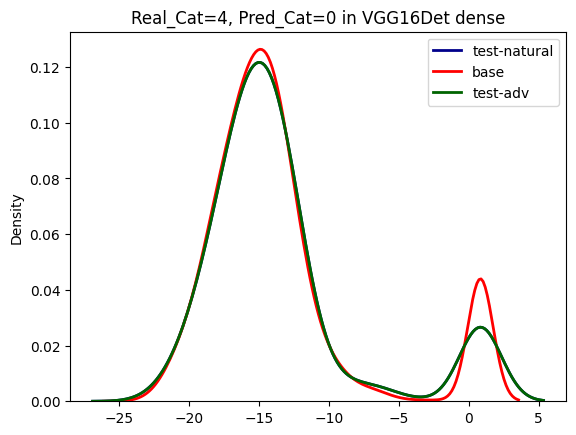

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


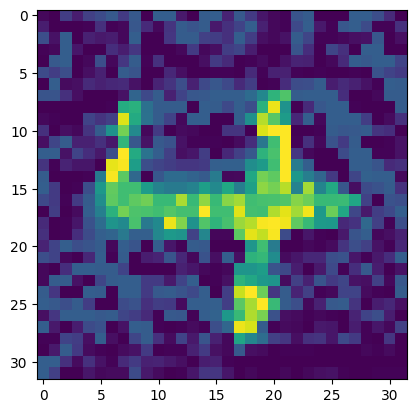

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

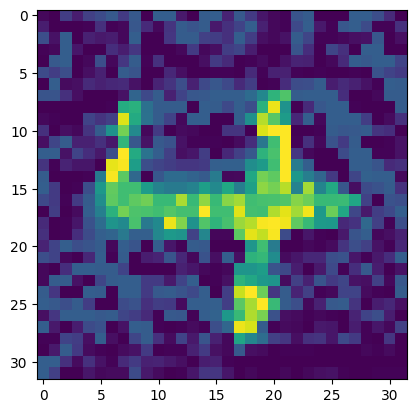

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.0564192000554082
distancia energia distribucion base y el ejemplo natural  1.043468394440035


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.0874983251553316
distancia energia distribucion base y el ejemplo adversario  1.1013534959297429


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-976-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-976-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

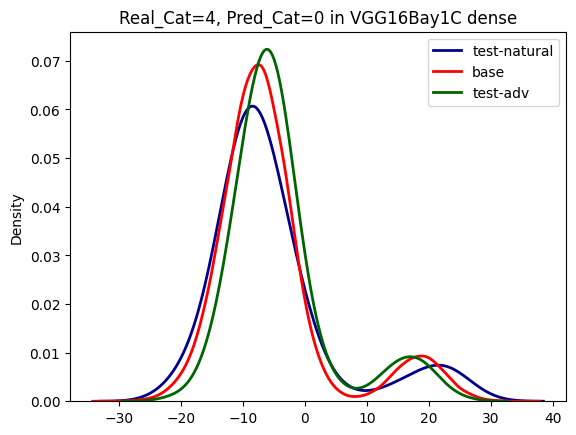

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [350]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [351]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [352]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [353]:
vgg_full_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 3s 197ms/step - loss: -1.0329 - accuracy: 0.9802


[-1.032897710800171, 0.9802083373069763]

In [354]:
vgg_det_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 1s 61ms/step - loss: 0.0042 - accuracy: 0.9979


[0.004224824719130993, 0.9979166388511658]

In [355]:
vgg_1c_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 1s 73ms/step - loss: -1.0748 - accuracy: 1.0000


[-1.0748428106307983, 1.0]

### 100 Bayesiano

In [356]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [357]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [358]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [359]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [360]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [361]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


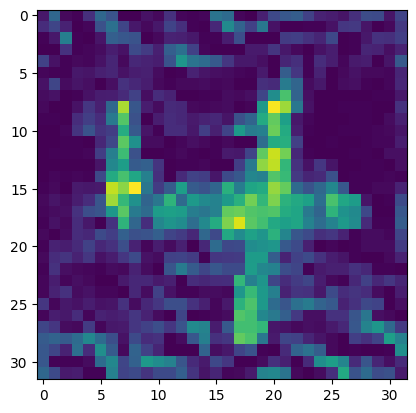

In [362]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [363]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [364]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [365]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [366]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.4911794523673754
distancia energia distribucion base y el ejemplo natural  1.0525058476764573


In [367]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [368]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.586944399389756
distancia energia distribucion base y el ejemplo adversario  1.9671655130849013


In [369]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-370-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-370-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

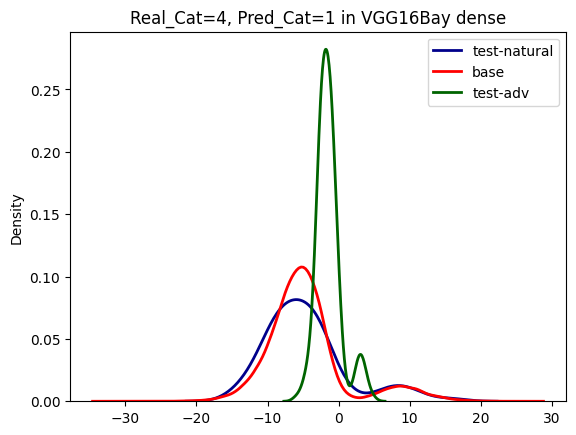

In [370]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [52]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


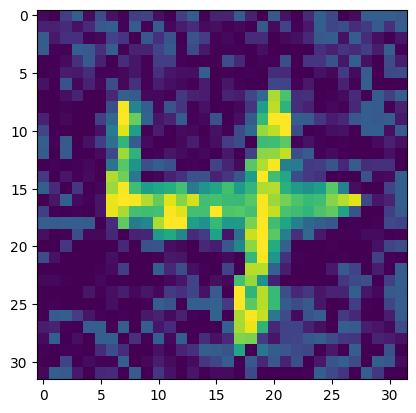

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[1]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

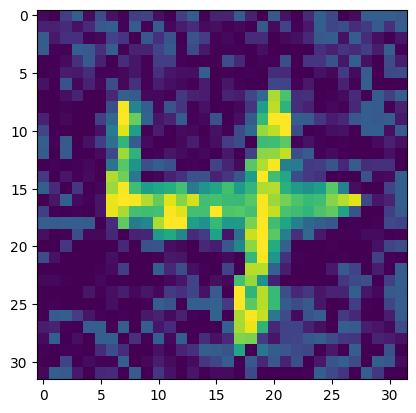

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  0.8747458191801949
distancia det energia distribucion base y el ejemplo natural  0.6477194127543661


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.8747458191801949
distancia energia distribucion base y el ejemplo adversario  0.6477194127543661


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-2854-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-2854-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

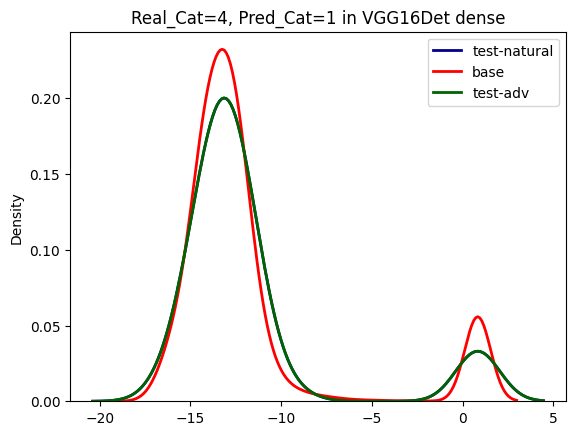

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


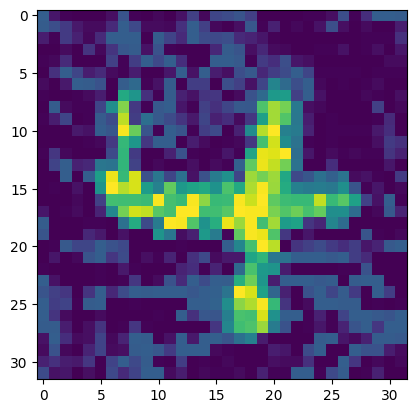

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

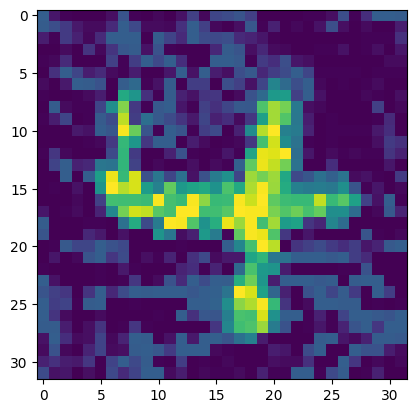

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.7199733697089368
distancia energia distribucion base y el ejemplo natural  0.9701547828848851


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.520709826552169
distancia energia distribucion base y el ejemplo adversario  0.935498540897123


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1027-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1027-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

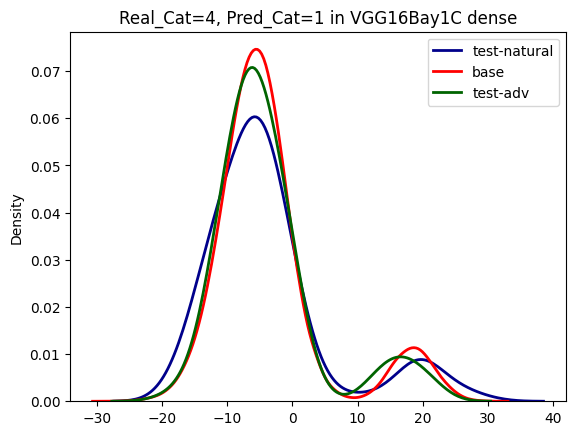

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [371]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [372]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [373]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [374]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 3s 199ms/step - loss: -1.0311 - accuracy: 0.9821


[-1.0310797691345215, 0.9821428656578064]

In [375]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 70ms/step - loss: 0.0137 - accuracy: 0.9967


[0.013721774332225323, 0.9966517686843872]

In [376]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 112ms/step - loss: -1.0629 - accuracy: 0.9944


[-1.0629254579544067, 0.9944196343421936]

### 100 Bayesiano

In [377]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [378]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [379]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [380]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [381]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [382]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


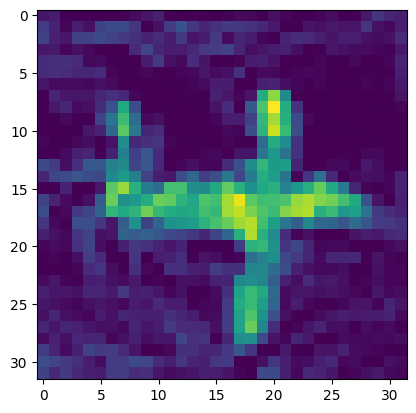

In [383]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [384]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [385]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [386]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [387]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.696187340418758
distancia energia distribucion base y el ejemplo natural  1.409708660273789


In [388]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [389]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.32362761685376
distancia energia distribucion base y el ejemplo adversario  1.6448338078277749


In [390]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-391-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-391-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

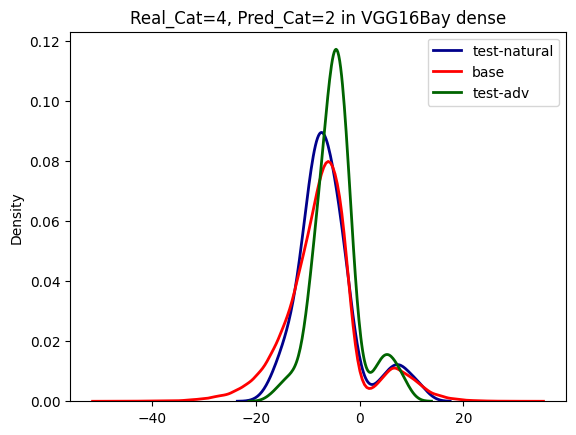

In [391]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


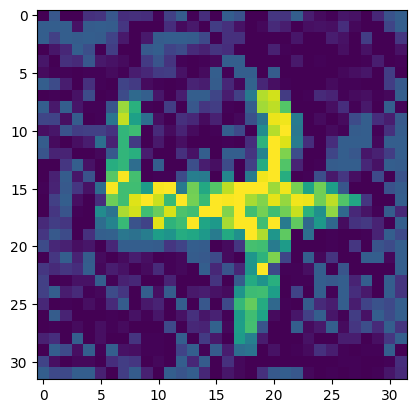

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[4]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

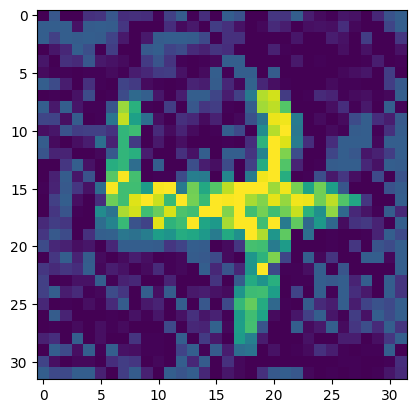

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.867080910570387
distancia det energia distribucion base y el ejemplo natural  1.6556507648633807


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.867080910570387
distancia energia distribucion base y el ejemplo adversario  1.6556507648633807


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1063-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1063-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

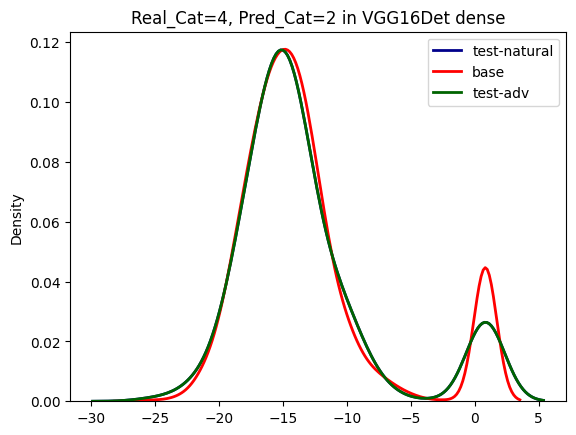

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


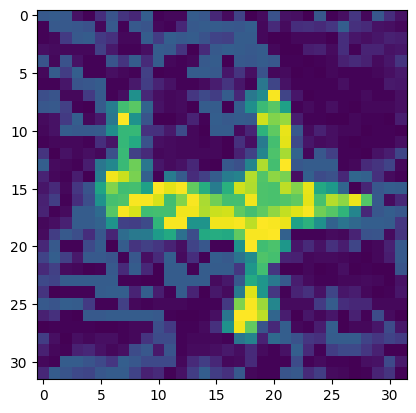

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

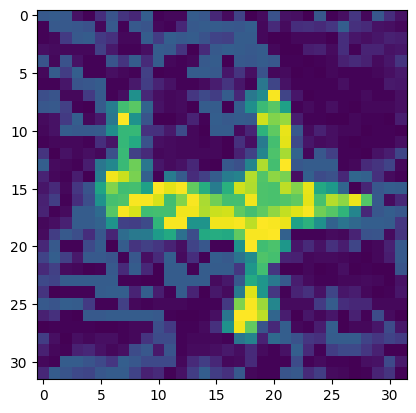

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.697326020970807
distancia energia distribucion base y el ejemplo natural  0.9848709889233066


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2118108787552924
distancia energia distribucion base y el ejemplo adversario  1.1185630910140054


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1078-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1078-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

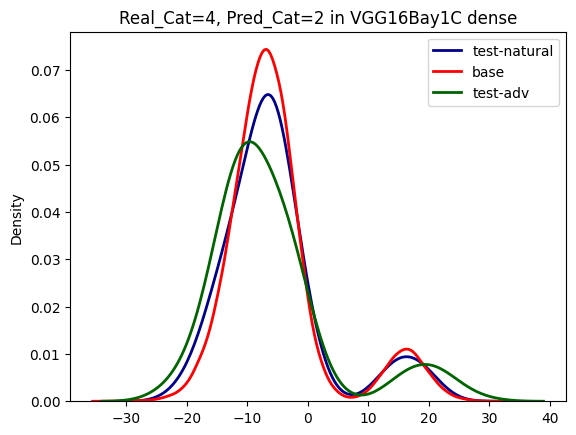

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [392]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [393]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [394]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [395]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 3s 197ms/step - loss: -1.0412 - accuracy: 0.9888


[-1.0412336587905884, 0.9888392686843872]

In [396]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 67ms/step - loss: 0.0127 - accuracy: 0.9978


[0.012672459706664085, 0.9977678656578064]

In [397]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 75ms/step - loss: -1.0490 - accuracy: 0.9967


[-1.0489661693572998, 0.9966517686843872]

### 100 Bayesiano

In [398]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [399]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [400]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [401]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [402]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [403]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


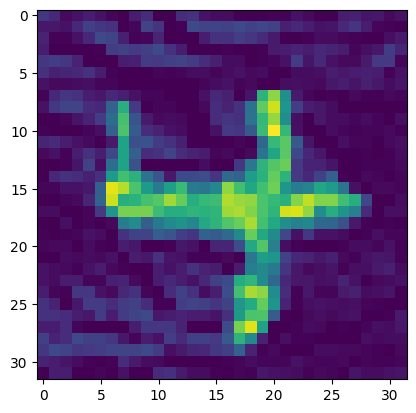

In [404]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [405]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [406]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [407]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [408]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.345364466647624
distancia energia distribucion base y el ejemplo natural  1.1987212976057122


In [409]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [410]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.606934271155356
distancia energia distribucion base y el ejemplo adversario  1.6437044765030646


In [411]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-412-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-412-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

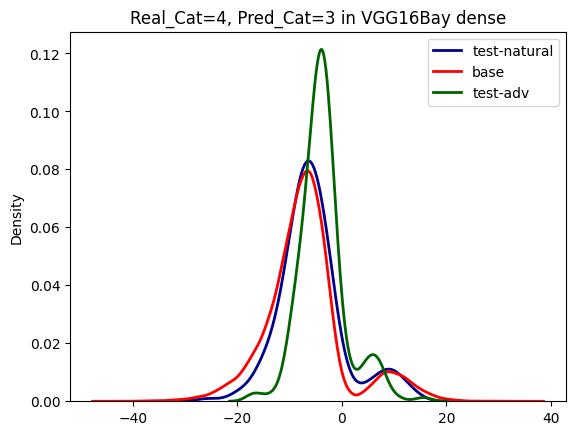

In [412]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


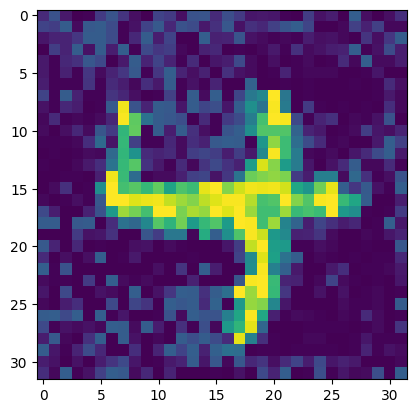

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[3]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

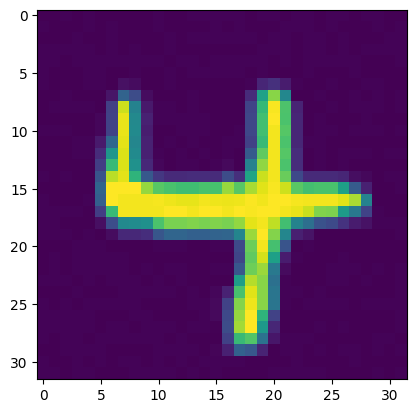

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.7192911335232823
distancia det energia distribucion base y el ejemplo natural  1.5336698601893943


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7192911335232823
distancia energia distribucion base y el ejemplo adversario  1.5336698601893943


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1114-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1114-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

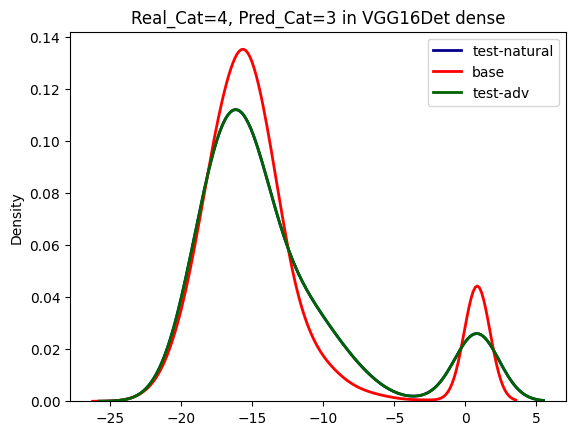

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


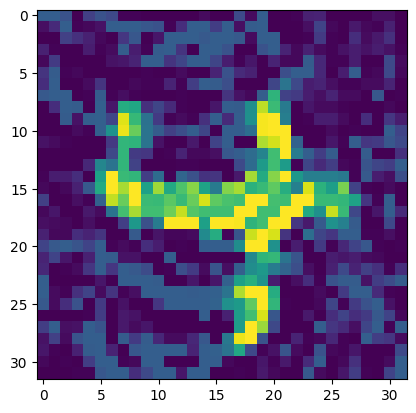

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

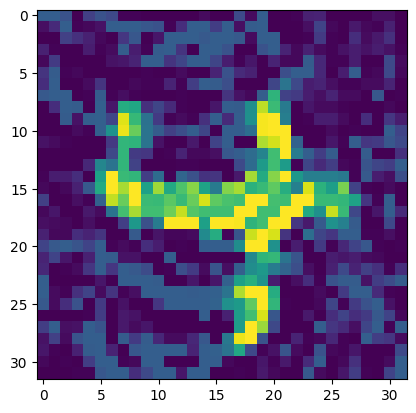

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.720508813652343
distancia energia distribucion base y el ejemplo natural  0.9849223752824826


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.93825055757411
distancia energia distribucion base y el ejemplo adversario  1.22590505101071


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1129-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1129-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

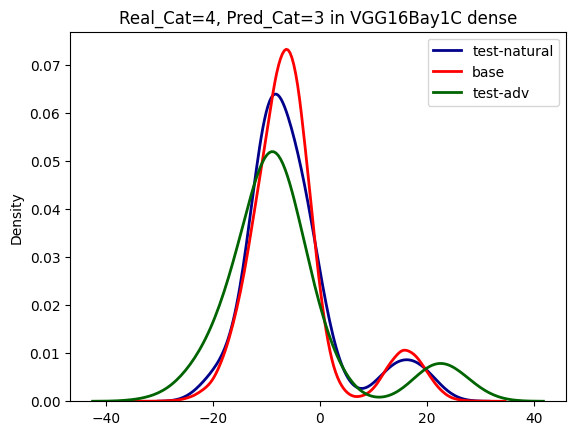

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [413]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [414]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [415]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [416]:
vgg_full_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 3s 206ms/step - loss: -0.8559 - accuracy: 0.9362


[-0.8558536171913147, 0.9361979365348816]

In [417]:
vgg_det_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 1s 82ms/step - loss: 0.0532 - accuracy: 0.9883


[0.053218696266412735, 0.98828125]

In [418]:
vgg_1c_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 1s 114ms/step - loss: -1.0348 - accuracy: 0.9948


[-1.0348384380340576, 0.9947916865348816]

### 100 Bayesiano

In [419]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [420]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [421]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [422]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [423]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [424]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


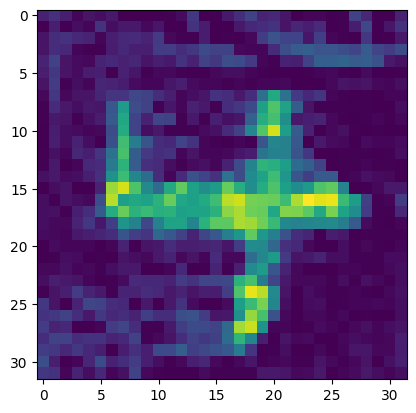

In [425]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [426]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [427]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [428]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [429]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.9111234517006195
distancia energia distribucion base y el ejemplo natural  1.1508293201531707


In [430]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [431]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.0856257424943534
distancia energia distribucion base y el ejemplo adversario  1.3054003254075328


In [432]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-433-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-433-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

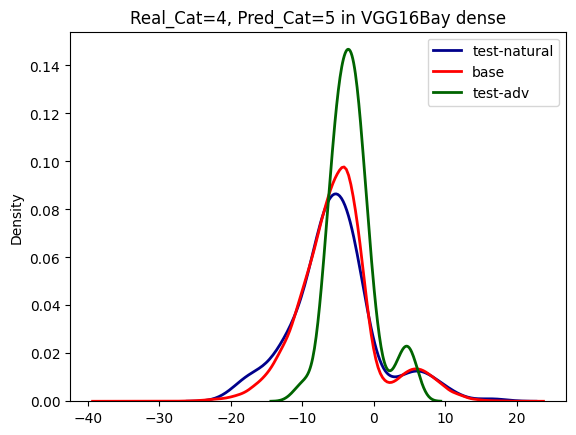

In [433]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


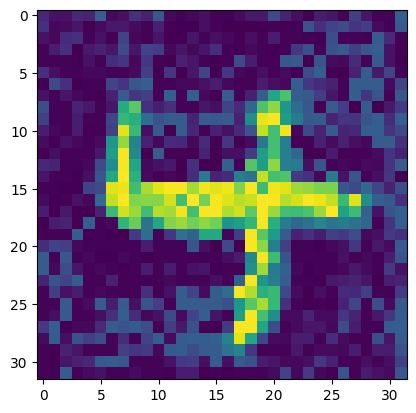

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[5]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

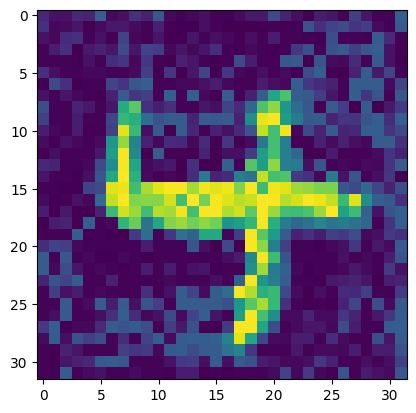

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.6901717895321777
distancia det energia distribucion base y el ejemplo natural  1.3694528870502347


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.6901717895321777
distancia energia distribucion base y el ejemplo adversario  1.3694528870502347


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1165-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1165-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

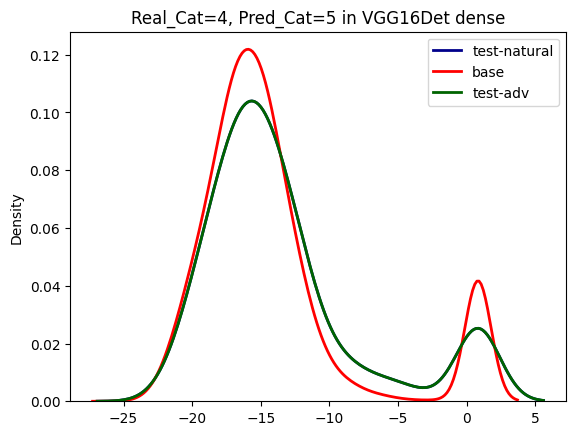

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


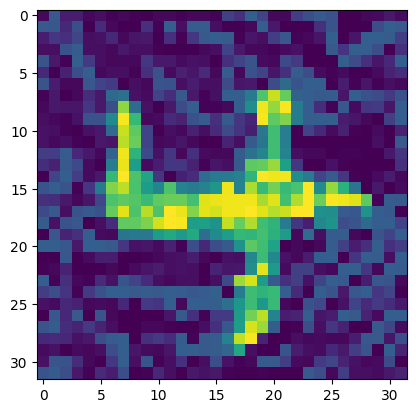

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

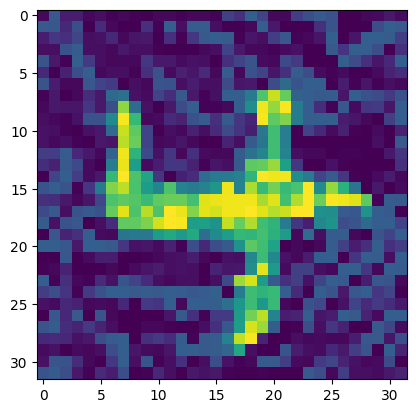

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.4785846441604282
distancia energia distribucion base y el ejemplo natural  0.9050694713363676


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.784393539961893
distancia energia distribucion base y el ejemplo adversario  0.9802204079135528


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1180-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1180-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

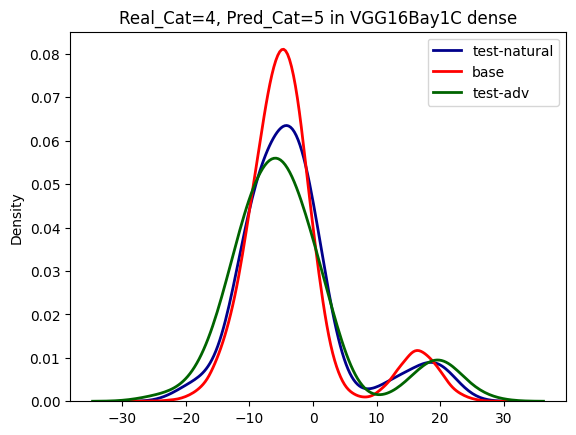

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [434]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [435]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [436]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [437]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 198ms/step - loss: -1.0154 - accuracy: 0.9748


[-1.015363097190857, 0.9747596383094788]

In [438]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 84ms/step - loss: 0.0412 - accuracy: 0.9916


[0.041191015392541885, 0.9915865659713745]

In [439]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 89ms/step - loss: -1.0287 - accuracy: 0.9880


[-1.0286991596221924, 0.9879807829856873]

### 100 Bayesiano

In [440]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [441]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [442]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [443]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [444]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [445]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  4


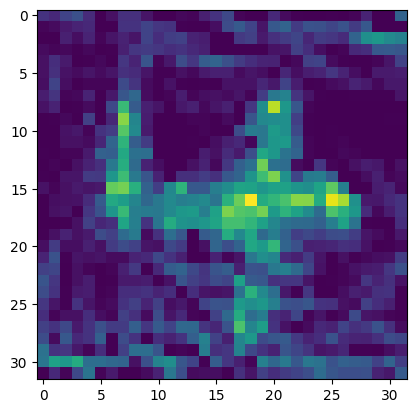

In [446]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [447]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[8]
[6]


In [448]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [449]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [450]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.87697562826727
distancia energia distribucion base y el ejemplo natural  1.7845298551075812


In [451]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [452]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  10.761521073327744
distancia energia distribucion base y el ejemplo adversario  2.830650542556453


In [453]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-454-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-454-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

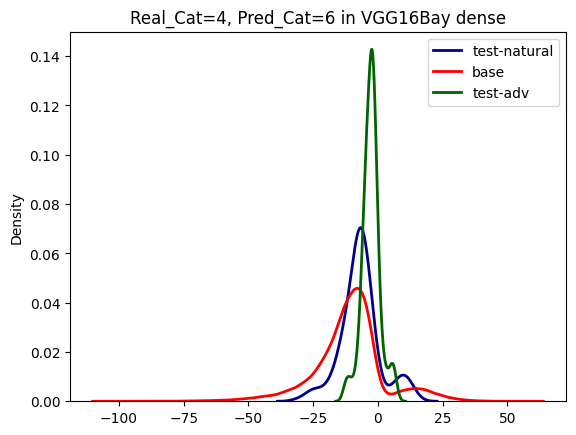

In [454]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


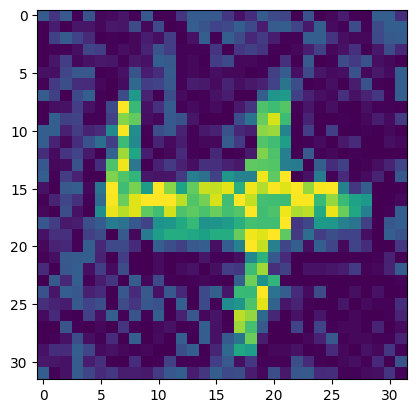

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[6]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

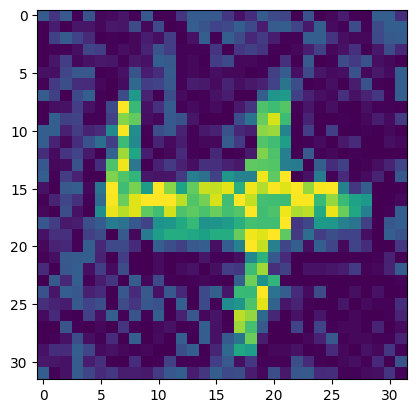

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.40660967709969
distancia det energia distribucion base y el ejemplo natural  1.2503051330801271


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.40660967709969
distancia energia distribucion base y el ejemplo adversario  1.2503051330801271


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1216-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1216-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

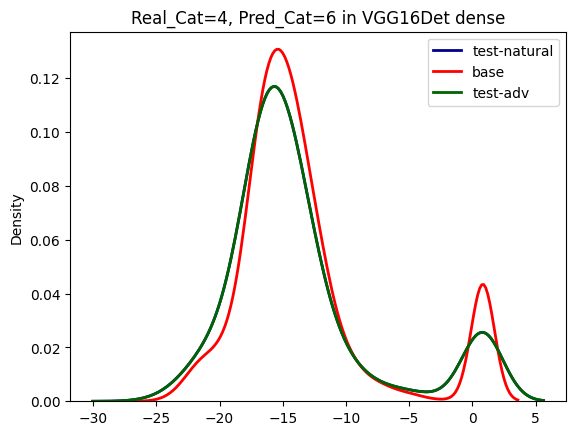

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


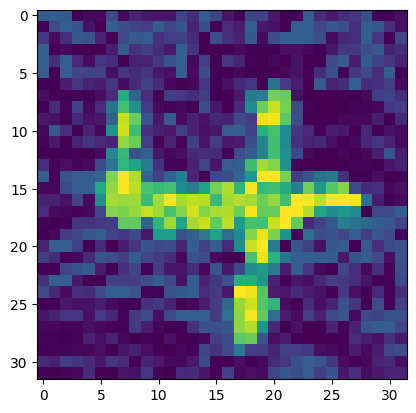

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

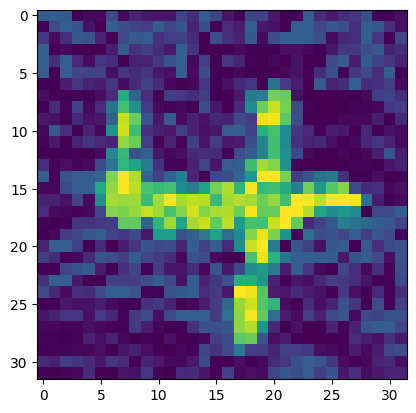

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.8986952909140027
distancia energia distribucion base y el ejemplo natural  0.9985797264476483


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9021630547902584
distancia energia distribucion base y el ejemplo adversario  0.9859916877987598


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1231-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1231-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

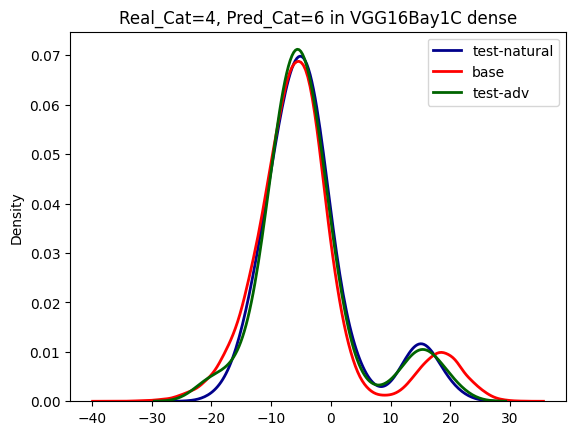

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [455]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [456]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [457]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [458]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 272ms/step - loss: -1.0272 - accuracy: 0.9721


[-1.027176856994629, 0.9720982313156128]

In [459]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 66ms/step - loss: 0.0214 - accuracy: 0.9922


[0.02143479697406292, 0.9921875]

In [460]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 85ms/step - loss: -1.0488 - accuracy: 0.9944


[-1.0488159656524658, 0.9944196343421936]

### 100 Bayesiano

In [461]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [462]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [463]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [464]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [465]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [466]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


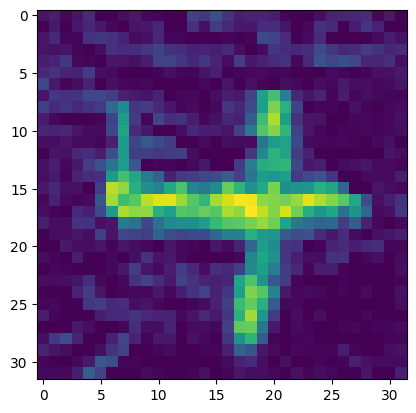

In [467]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [468]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [469]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [470]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [471]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.878362879295275
distancia energia distribucion base y el ejemplo natural  1.0780170299518415


In [472]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [473]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.226499013494406
distancia energia distribucion base y el ejemplo adversario  1.5838691326964778


In [474]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-475-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-475-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

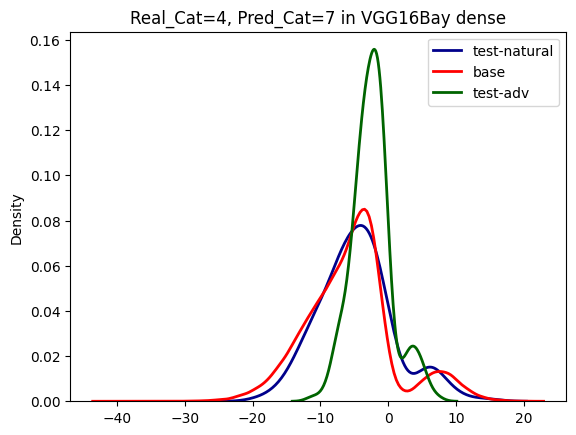

In [475]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


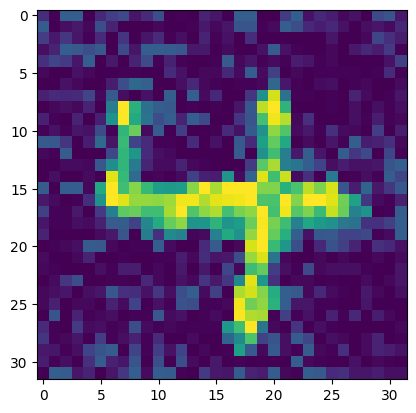

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[7]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

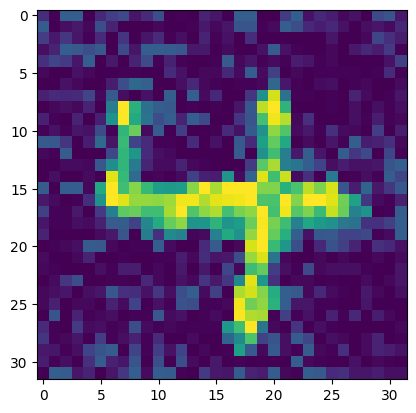

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.443168221520526
distancia det energia distribucion base y el ejemplo natural  1.26222517491751


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.443168221520526
distancia energia distribucion base y el ejemplo adversario  1.26222517491751


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1267-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1267-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

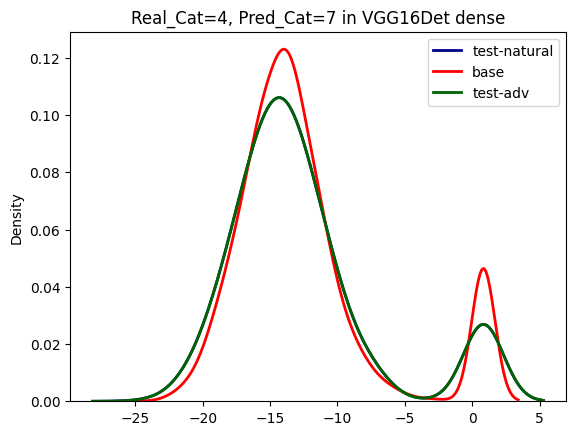

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


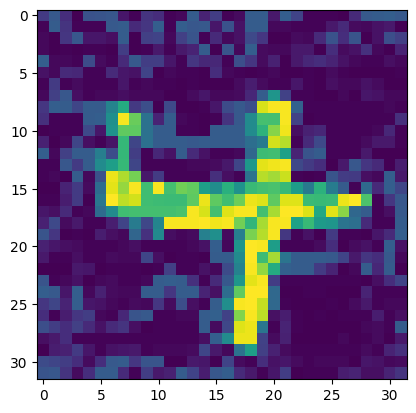

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

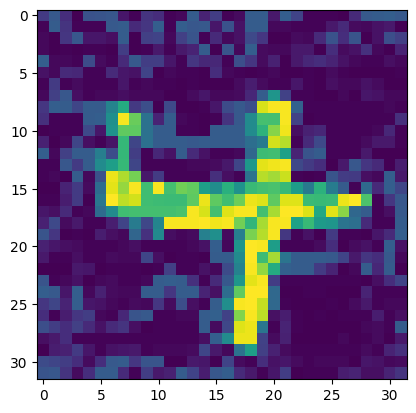

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.562398599801984
distancia energia distribucion base y el ejemplo natural  0.9271737184645734


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.7363777138858656
distancia energia distribucion base y el ejemplo adversario  1.2503614109017767


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1282-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1282-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

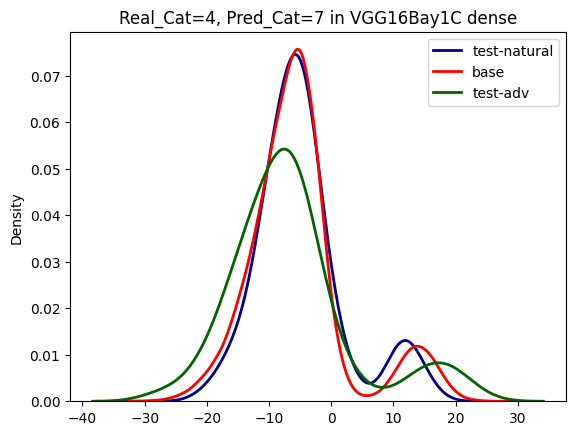

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [476]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [477]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [478]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [479]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 198ms/step - loss: -1.0172 - accuracy: 0.9880


[-1.0172077417373657, 0.9879807829856873]

In [480]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 65ms/step - loss: 0.0141 - accuracy: 0.9976


[0.014121459797024727, 0.9975961446762085]

In [481]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 86ms/step - loss: -1.0675 - accuracy: 0.9964


[-1.067512035369873, 0.9963942170143127]

### 100 Bayesiano

In [482]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [483]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [484]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [485]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [486]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [487]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


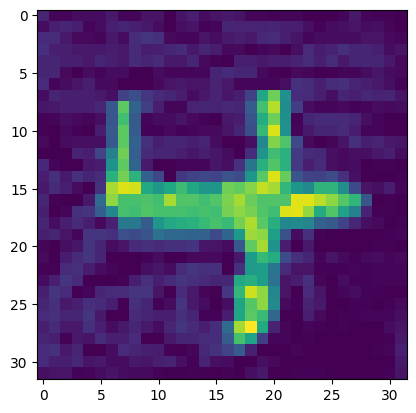

In [488]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [489]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [490]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [491]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [492]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.515852083937552
distancia energia distribucion base y el ejemplo natural  1.5126253021973854


In [493]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [494]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.99220270955267
distancia energia distribucion base y el ejemplo adversario  2.3769965434345104


In [495]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-496-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-496-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

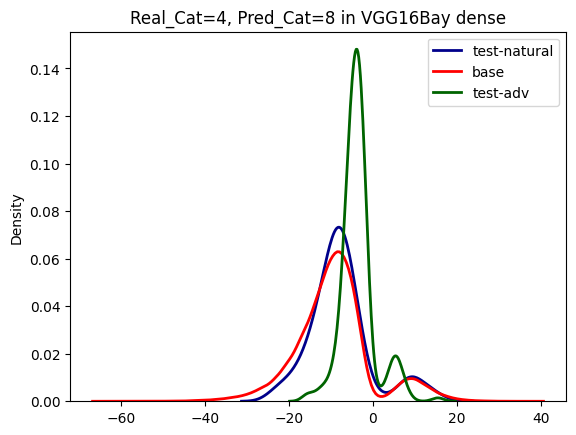

In [496]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


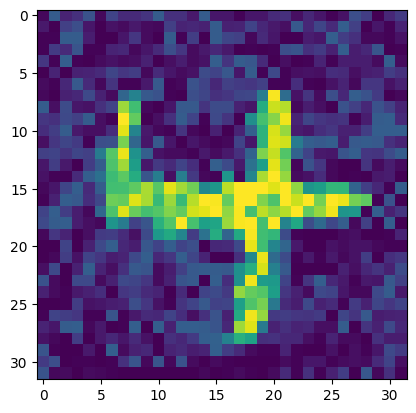

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[8]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

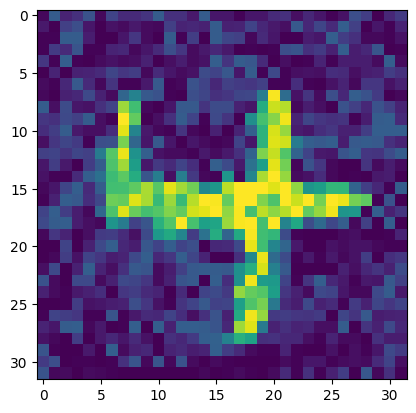

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.7088734540996553
distancia det energia distribucion base y el ejemplo natural  1.469860262029595


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7088734540996553
distancia energia distribucion base y el ejemplo adversario  1.469860262029595


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1318-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1318-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

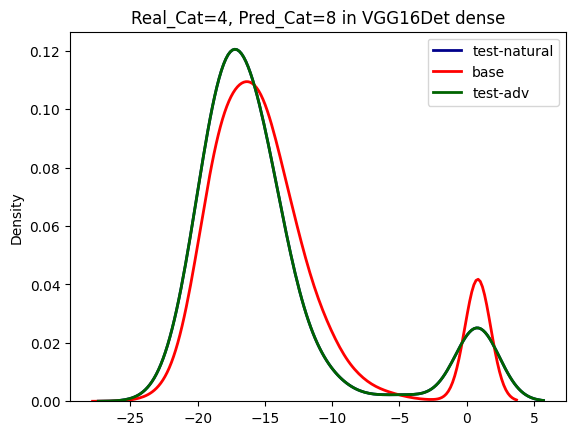

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


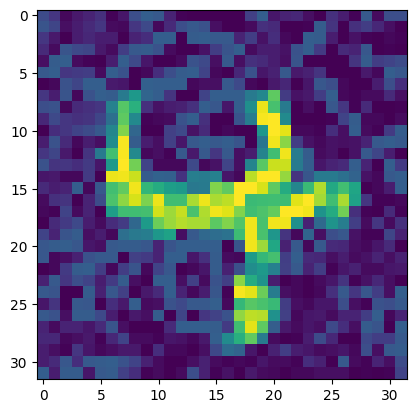

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

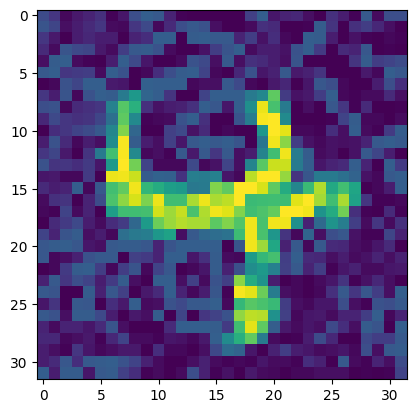

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.848690924112721
distancia energia distribucion base y el ejemplo natural  1.0365562593982416


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.6845533424468995
distancia energia distribucion base y el ejemplo adversario  1.4442848480679364


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-3175-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-3175-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

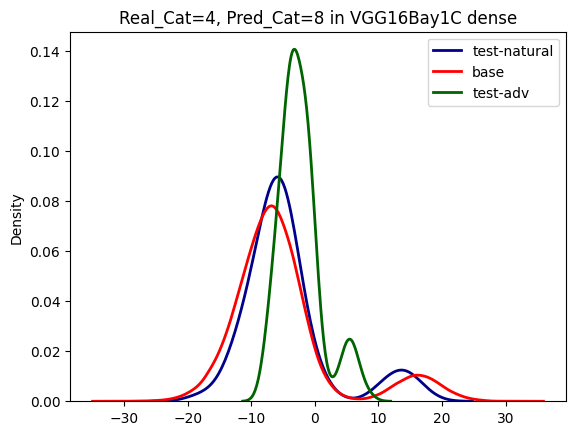

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [497]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [498]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [499]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [500]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 295ms/step - loss: -1.0504 - accuracy: 0.9944


[-1.0504403114318848, 0.9944196343421936]

In [501]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 70ms/step - loss: 0.0207 - accuracy: 0.9922


[0.02072400227189064, 0.9921875]

In [502]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 76ms/step - loss: -1.0066 - accuracy: 0.9844


[-1.006649374961853, 0.984375]

### 100 Bayesiano

In [503]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [504]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [505]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [506]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [507]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [508]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


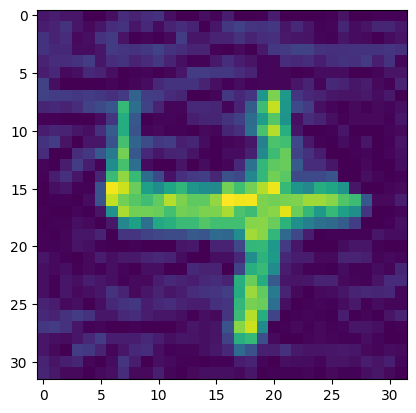

In [509]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [510]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [511]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [512]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [513]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.5751959588457742
distancia energia distribucion base y el ejemplo natural  1.2542833928510222


In [514]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [515]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.304264571491954
distancia energia distribucion base y el ejemplo adversario  1.8480056871785844


In [516]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-517-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-517-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

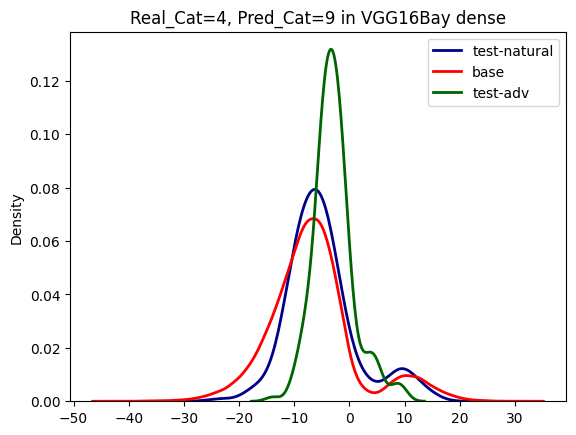

In [517]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  4


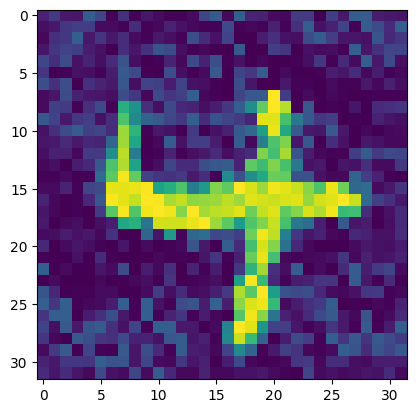

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[9]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

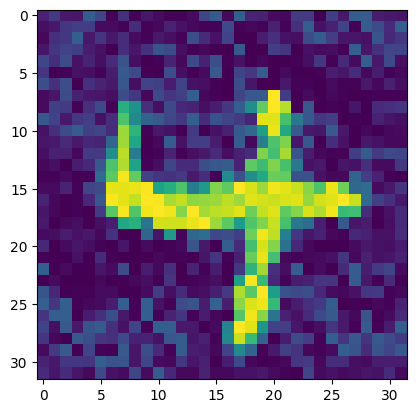

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.8093051769907893
distancia det energia distribucion base y el ejemplo natural  1.3047930919226882


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.8093051769907893
distancia energia distribucion base y el ejemplo adversario  1.3047930919226882


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1369-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1369-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

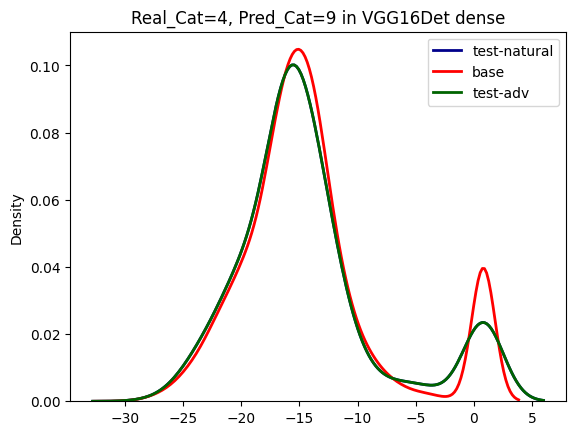

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  4


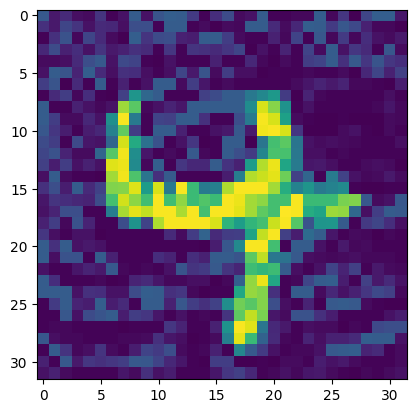

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

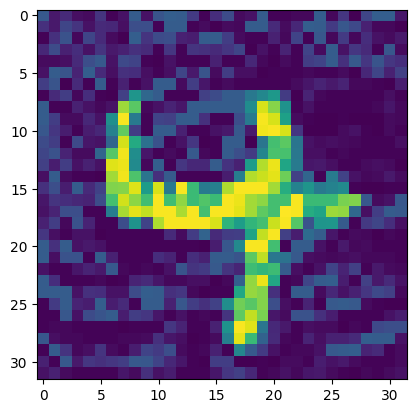

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.142983942135146
distancia energia distribucion base y el ejemplo natural  1.051724707485117


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.64269017457435
distancia energia distribucion base y el ejemplo adversario  1.3438680693630487


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1384-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1384-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

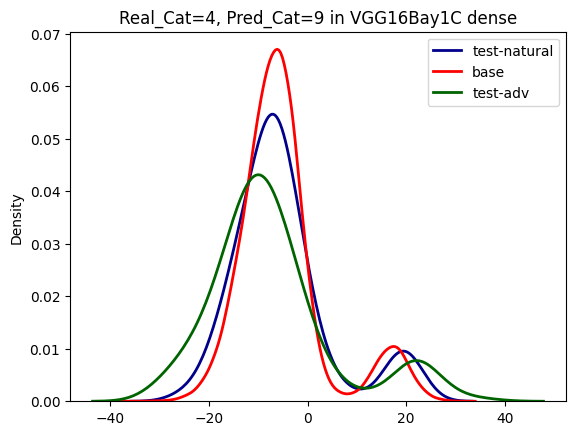

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 5

## Ataque 0

In [518]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 5
Vic_loc = 7
Cat = 0

In [519]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [520]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [521]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 205ms/step - loss: -0.9742 - accuracy: 0.9543


[-0.9742324352264404, 0.9543269276618958]

In [522]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 71ms/step - loss: 0.0121 - accuracy: 0.9964


[0.01205806341022253, 0.9963942170143127]

In [523]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 89ms/step - loss: -1.0537 - accuracy: 0.9976


[-1.0536831617355347, 0.9975961446762085]

### 100 Bayesiano

In [524]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [525]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [526]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [527]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [528]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [529]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  5


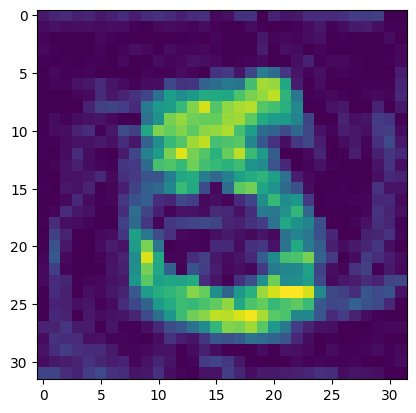

In [530]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [531]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [532]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [533]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [534]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.8603136349037888
distancia energia distribucion base y el ejemplo natural  1.3787915174483523


In [535]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [536]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.095931255003053
distancia energia distribucion base y el ejemplo adversario  1.4762543213131483


In [537]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-538-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-538-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

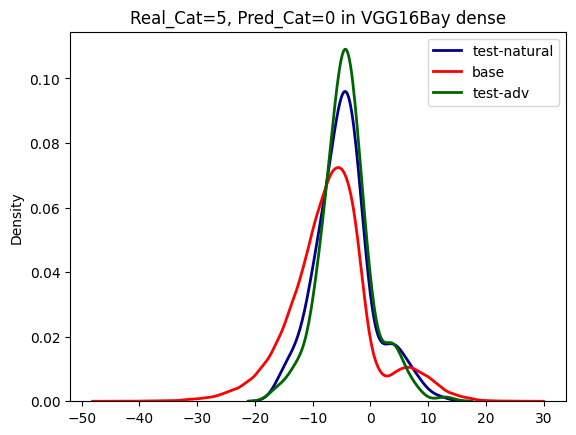

In [538]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


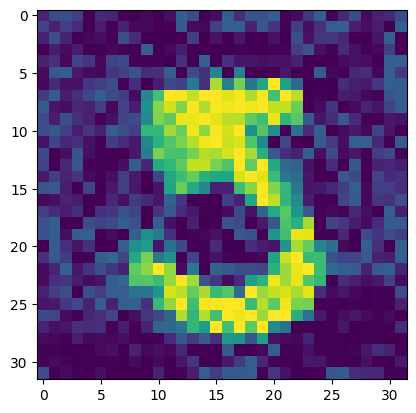

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[0]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

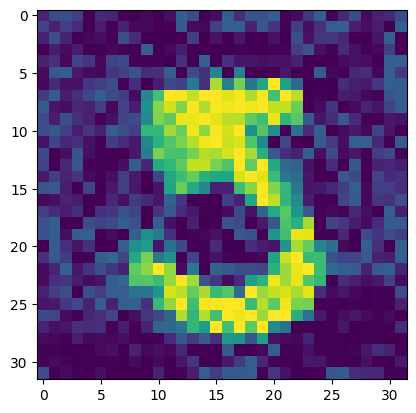

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.1266085854756125
distancia det energia distribucion base y el ejemplo natural  1.130186283882566


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.1266085854756125
distancia energia distribucion base y el ejemplo adversario  1.130186283882566


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1420-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1420-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

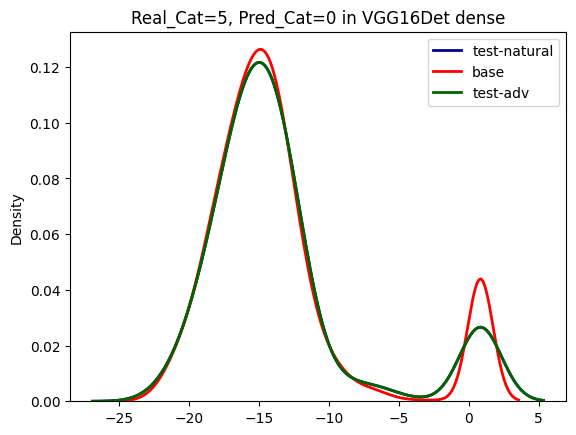

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


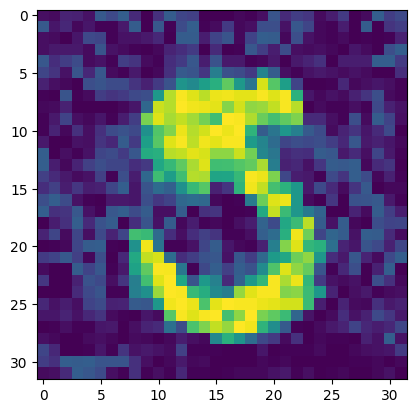

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

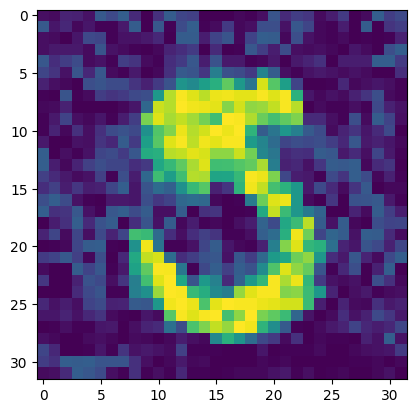

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.992285753257886
distancia energia distribucion base y el ejemplo natural  1.0289271076697137


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.8398359790500436
distancia energia distribucion base y el ejemplo adversario  1.1938655343803157


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1435-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1435-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

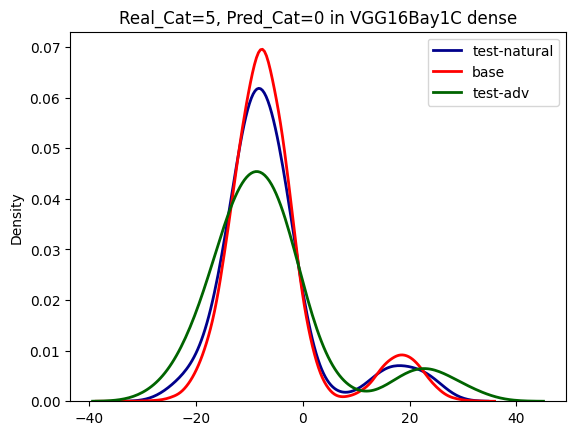

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [539]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [540]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [541]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [542]:
vgg_full_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 3s 200ms/step - loss: -1.0267 - accuracy: 0.9823


[-1.0266907215118408, 0.9822916388511658]

In [543]:
vgg_det_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 1s 62ms/step - loss: 0.0042 - accuracy: 0.9979


[0.004224824719130993, 0.9979166388511658]

In [544]:
vgg_1c_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 1s 85ms/step - loss: -1.0759 - accuracy: 1.0000


[-1.0759432315826416, 1.0]

### 100 Bayesiano

In [545]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [546]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [547]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [548]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [549]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [550]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  5


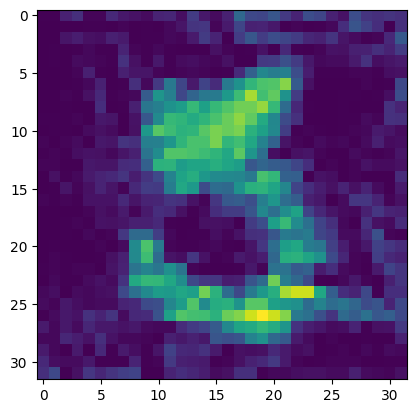

In [551]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [552]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [553]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [554]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [555]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.2398955738573845
distancia energia distribucion base y el ejemplo natural  0.9556026911376235


In [556]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [557]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.140522087568532
distancia energia distribucion base y el ejemplo adversario  1.7700340677390887


In [558]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-559-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-559-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

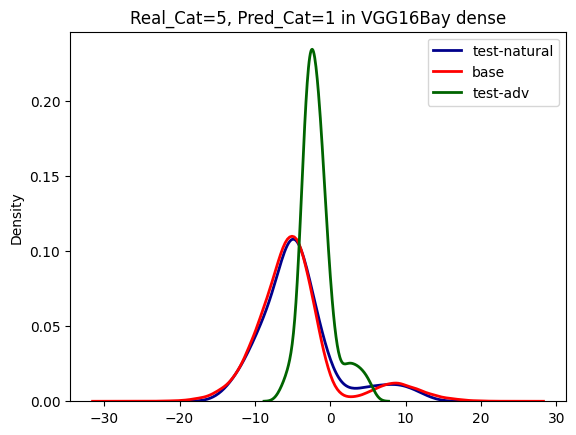

In [559]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


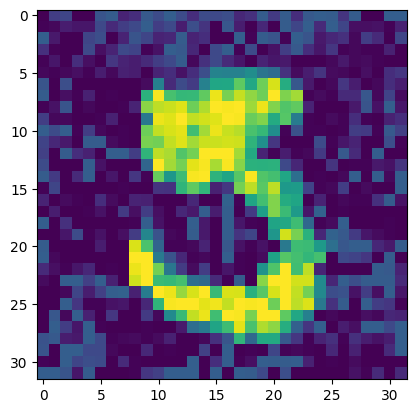

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[1]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

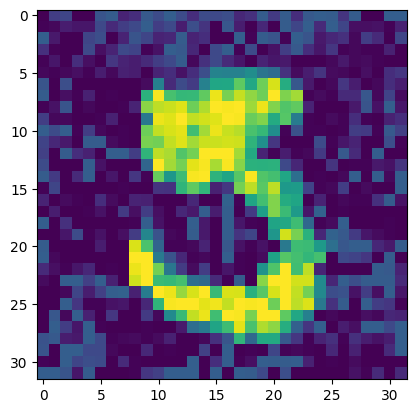

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  0.8747458191801949
distancia det energia distribucion base y el ejemplo natural  0.6477194127543661


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.8747458191801949
distancia energia distribucion base y el ejemplo adversario  0.6477194127543661


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1471-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1471-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

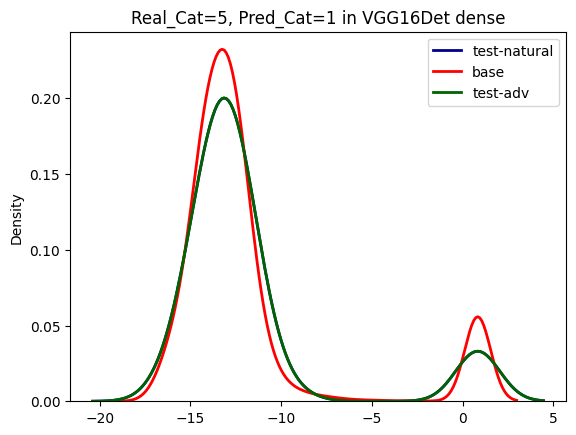

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


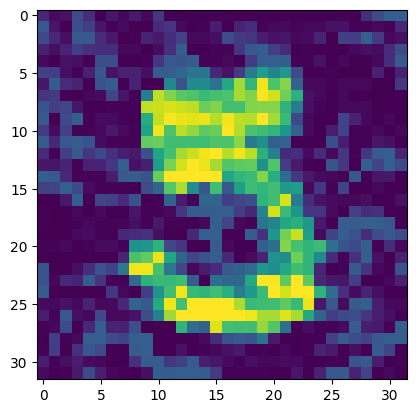

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

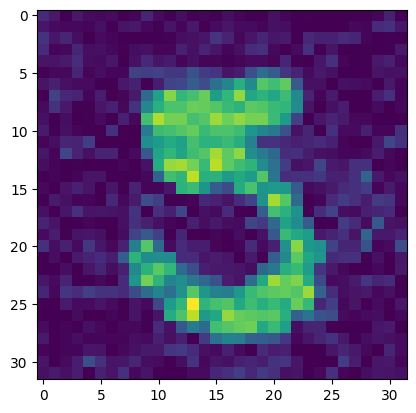

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.887760361342419
distancia energia distribucion base y el ejemplo natural  1.0029803821858232


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.651622163475619
distancia energia distribucion base y el ejemplo adversario  0.9528836312736187


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1486-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1486-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

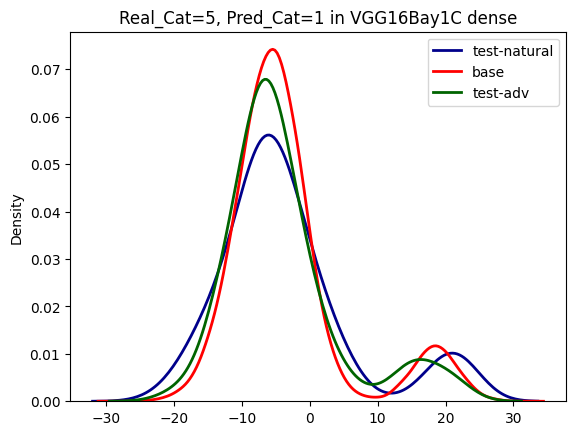

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [560]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [561]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [562]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [563]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 3s 213ms/step - loss: -1.0051 - accuracy: 0.9699


[-1.0051196813583374, 0.9698660969734192]

In [564]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 65ms/step - loss: 0.0137 - accuracy: 0.9967


[0.013721774332225323, 0.9966517686843872]

In [565]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 119ms/step - loss: -1.0612 - accuracy: 0.9944


[-1.0612075328826904, 0.9944196343421936]

### 100 Bayesiano

In [566]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [567]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [568]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [569]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [570]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [571]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  5


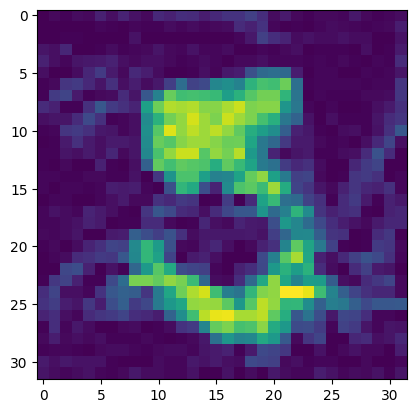

In [572]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [573]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [574]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [575]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [576]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.8520413410178644
distancia energia distribucion base y el ejemplo natural  1.4601428986162723


In [577]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [578]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.497591719392237
distancia energia distribucion base y el ejemplo adversario  2.101578847425583


In [579]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-580-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-580-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

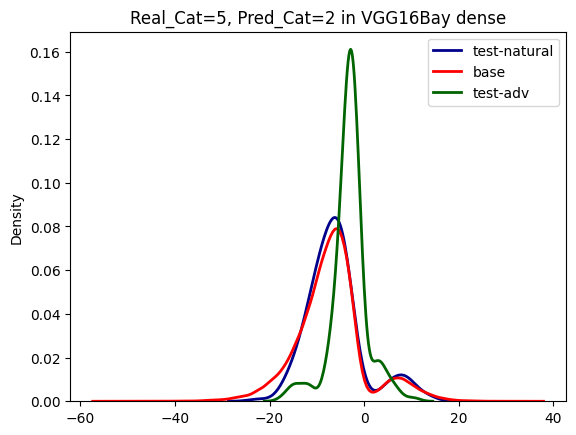

In [580]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


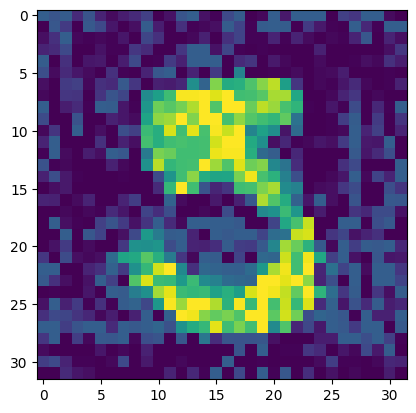

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[2]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

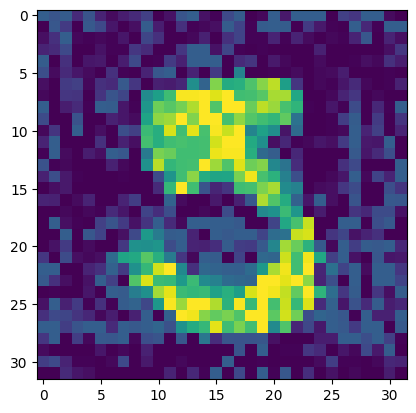

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.867080910570387
distancia det energia distribucion base y el ejemplo natural  1.6556507648633807


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.867080910570387
distancia energia distribucion base y el ejemplo adversario  1.6556507648633807


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1522-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1522-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

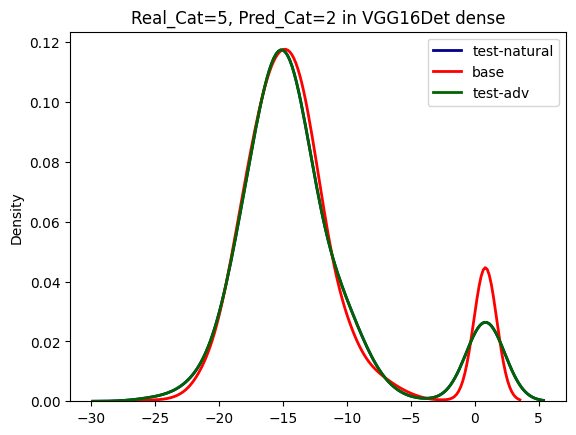

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


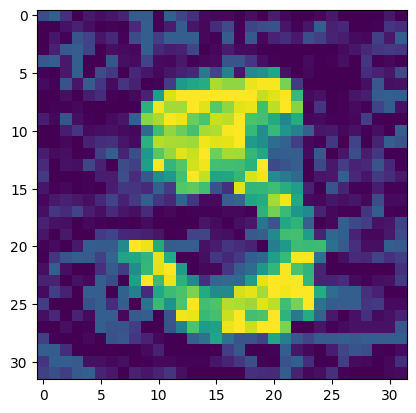

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

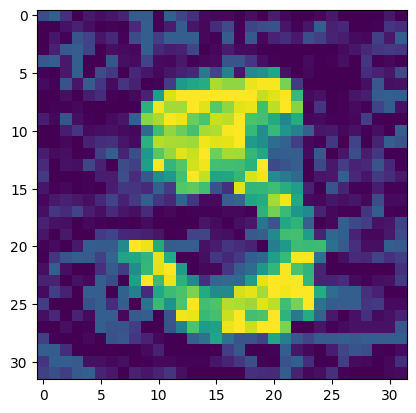

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.5836703806923134
distancia energia distribucion base y el ejemplo natural  0.9462957905642985


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.1352262862971236
distancia energia distribucion base y el ejemplo adversario  1.10054905699529


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1537-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1537-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

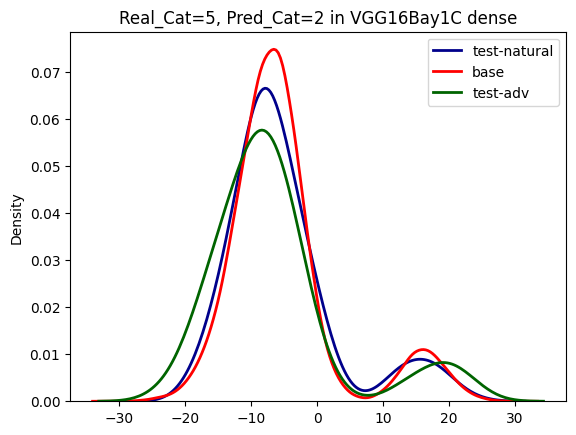

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [581]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [582]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [583]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [584]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 249ms/step - loss: -1.0536 - accuracy: 0.9866


[-1.053558111190796, 0.9866071343421936]

In [585]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 69ms/step - loss: 0.0127 - accuracy: 0.9978


[0.012672459706664085, 0.9977678656578064]

In [586]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 85ms/step - loss: -1.0481 - accuracy: 0.9955


[-1.048110842704773, 0.9955357313156128]

### 100 Bayesiano

In [587]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [588]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [589]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [590]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [591]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [592]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  5


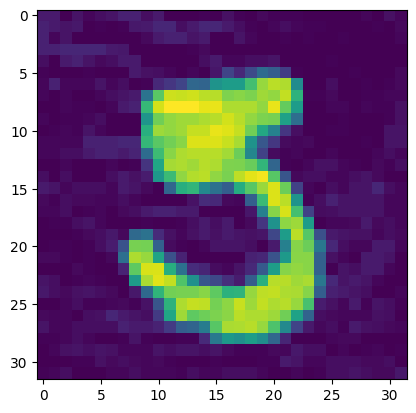

In [593]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [594]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [595]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [596]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [597]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.3605310223595213
distancia energia distribucion base y el ejemplo natural  1.1879795959152593


In [598]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [599]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.4070492796690255
distancia energia distribucion base y el ejemplo adversario  1.5590633675250112


In [600]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-601-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-601-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

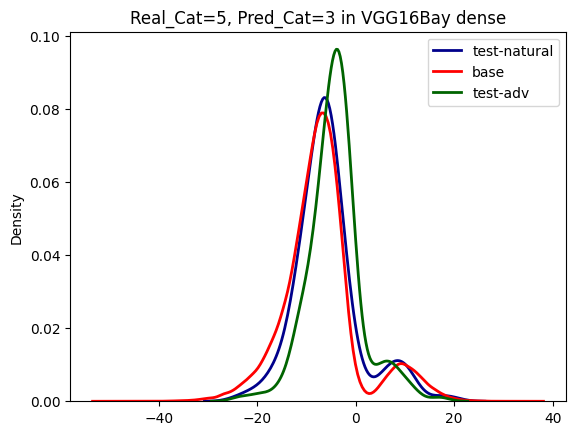

In [601]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


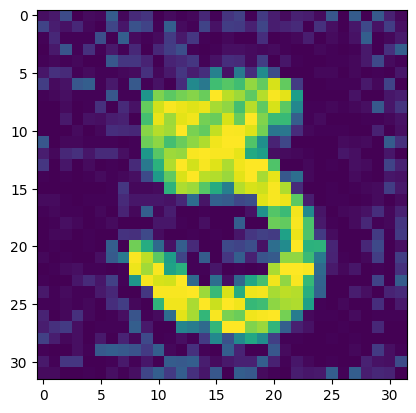

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[3]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

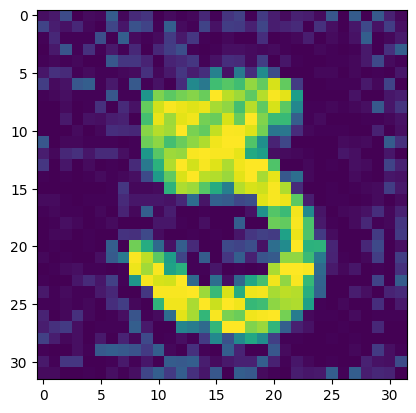

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.7192911335232823
distancia det energia distribucion base y el ejemplo natural  1.5336698601893943


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7192911335232823
distancia energia distribucion base y el ejemplo adversario  1.5336698601893943


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1573-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1573-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

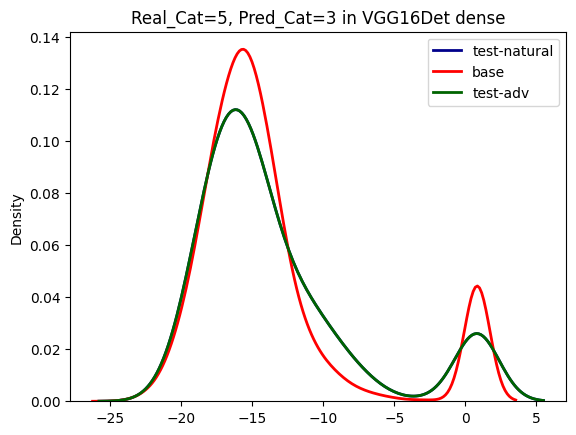

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


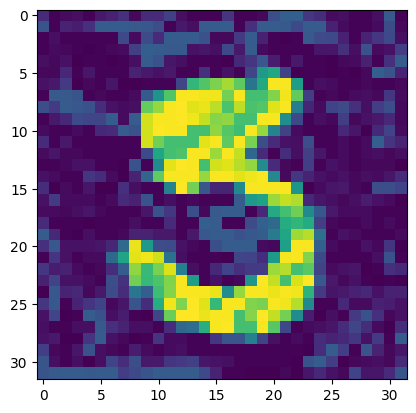

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

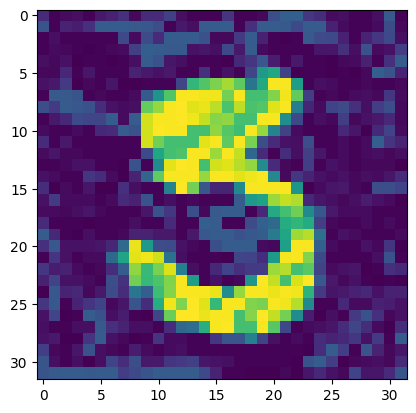

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.7096778688238534
distancia energia distribucion base y el ejemplo natural  0.9803585676508543


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.353424908018006
distancia energia distribucion base y el ejemplo adversario  1.463376208910495


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1588-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1588-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

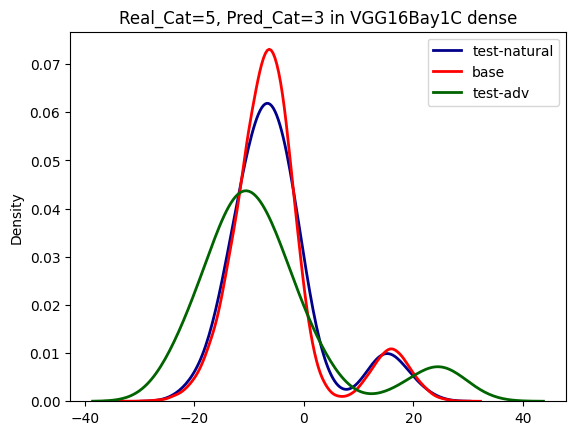

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [602]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [603]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [604]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [605]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 191ms/step - loss: -0.9646 - accuracy: 0.9675


[-0.9645500183105469, 0.9675480723381042]

In [606]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 94ms/step - loss: 0.0046 - accuracy: 0.9976


[0.004562061745673418, 0.9975961446762085]

In [607]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 97ms/step - loss: -1.0655 - accuracy: 0.9952


[-1.0654736757278442, 0.995192289352417]

### 100 Bayesiano

In [608]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [609]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [610]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [611]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [612]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [613]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  5


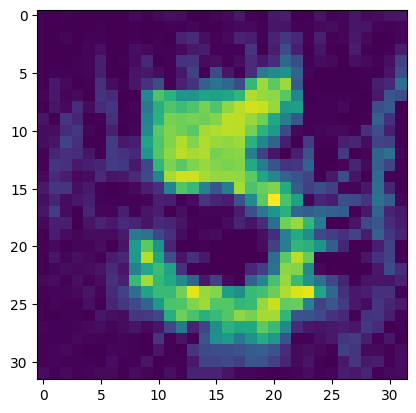

In [614]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [615]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [616]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [617]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [618]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.366489923961337
distancia energia distribucion base y el ejemplo natural  1.4526477865010399


In [619]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [620]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.898598837187612
distancia energia distribucion base y el ejemplo adversario  2.0557849721897696


In [621]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-622-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-622-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

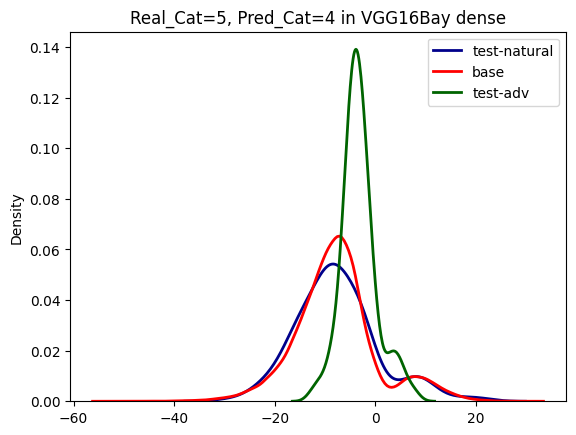

In [622]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


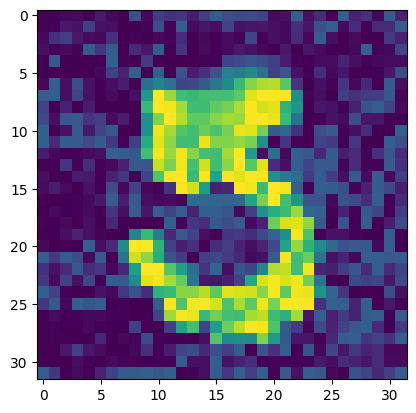

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[4]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

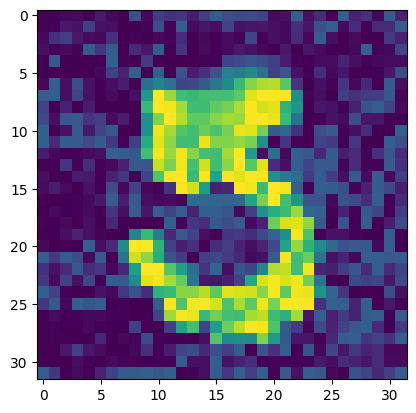

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.1606476531693124
distancia det energia distribucion base y el ejemplo natural  1.2755469300243563


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.1606476531693124
distancia energia distribucion base y el ejemplo adversario  1.2755469300243563


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1624-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1624-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

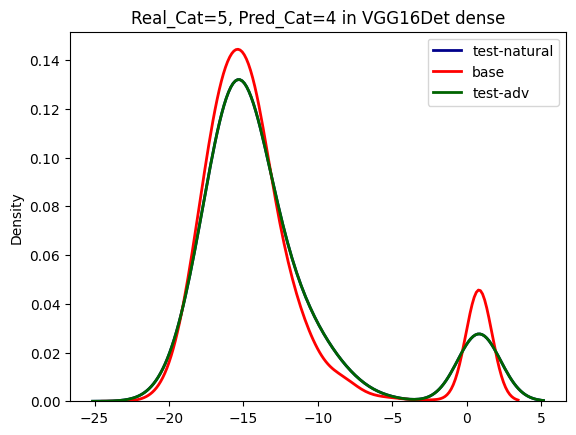

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


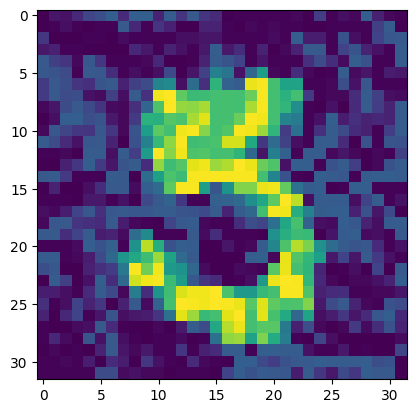

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

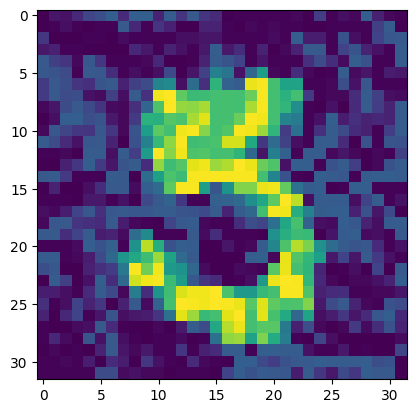

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.585397350602568
distancia energia distribucion base y el ejemplo natural  0.9543693542477947


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.1159797564342324
distancia energia distribucion base y el ejemplo adversario  1.0724852720968738


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1639-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1639-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

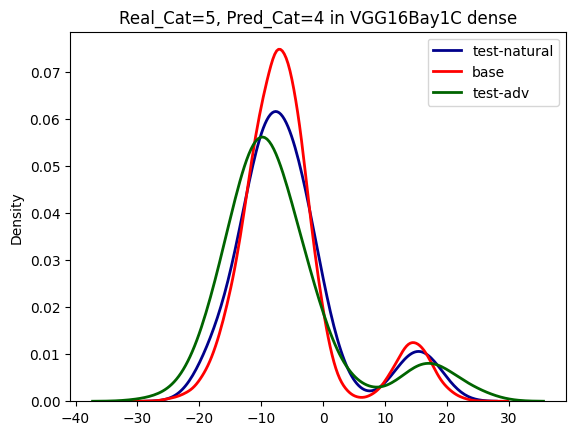

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [623]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [624]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [625]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [626]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 3s 230ms/step - loss: -1.0216 - accuracy: 0.9832


[-1.0215671062469482, 0.9831730723381042]

In [627]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 98ms/step - loss: 0.0412 - accuracy: 0.9916


[0.041191015392541885, 0.9915865659713745]

In [628]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 104ms/step - loss: -1.0225 - accuracy: 0.9892


[-1.0224673748016357, 0.989182710647583]

### 100 Bayesiano

In [629]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [630]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [631]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [632]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [633]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [634]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  5


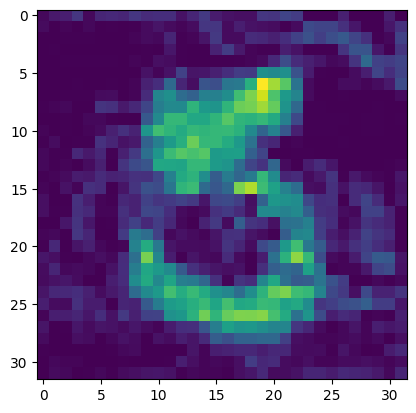

In [635]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [636]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [637]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [638]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [639]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  7.211846561502337
distancia energia distribucion base y el ejemplo natural  1.8765399129310911


In [640]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [641]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  9.679815909915034
distancia energia distribucion base y el ejemplo adversario  2.5161820254549276


In [642]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-643-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-643-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

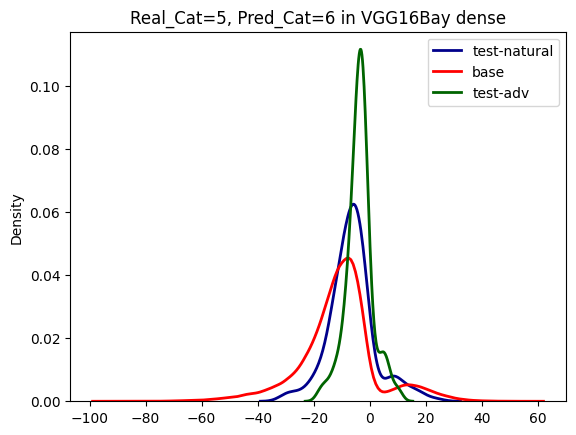

In [643]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


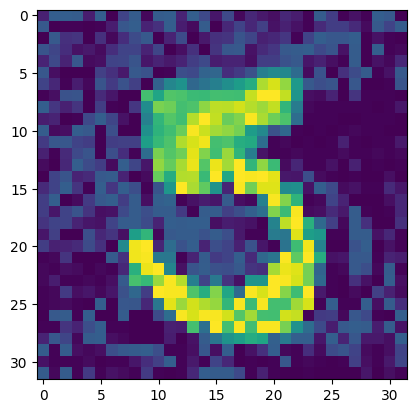

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[6]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

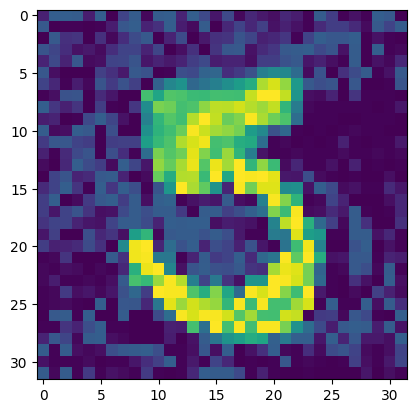

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.40660967709969
distancia det energia distribucion base y el ejemplo natural  1.2503051330801271


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.40660967709969
distancia energia distribucion base y el ejemplo adversario  1.2503051330801271


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1675-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1675-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

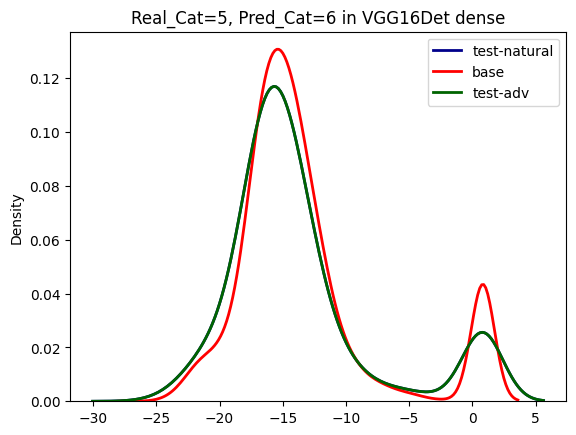

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


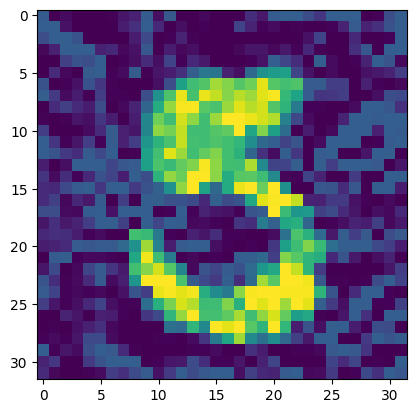

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

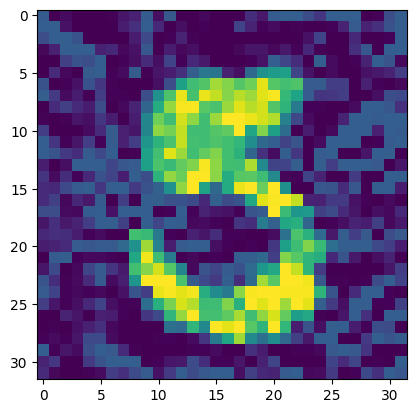

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.016577852032863
distancia energia distribucion base y el ejemplo natural  1.0338249490415916


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.067280298337743
distancia energia distribucion base y el ejemplo adversario  1.0526043389981725


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1690-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1690-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

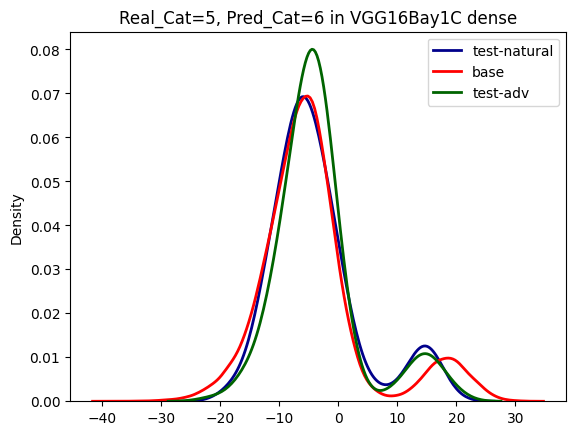

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [644]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [645]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [646]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [647]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 246ms/step - loss: -1.0231 - accuracy: 0.9810


[-1.0230741500854492, 0.9810267686843872]

In [648]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 70ms/step - loss: 0.0214 - accuracy: 0.9922


[0.02143479697406292, 0.9921875]

In [649]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 86ms/step - loss: -1.0536 - accuracy: 0.9944


[-1.0536211729049683, 0.9944196343421936]

### 100 Bayesiano

In [650]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [651]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [652]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [653]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [654]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [655]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  5


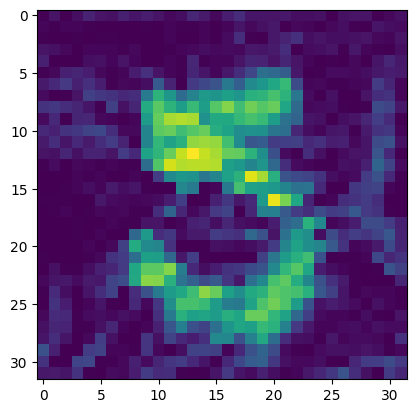

In [656]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [657]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [658]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [659]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [660]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.942740568493979
distancia energia distribucion base y el ejemplo natural  1.0997891455411477


In [661]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [662]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.103711949589142
distancia energia distribucion base y el ejemplo adversario  1.5345610159586656


In [663]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-664-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-664-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

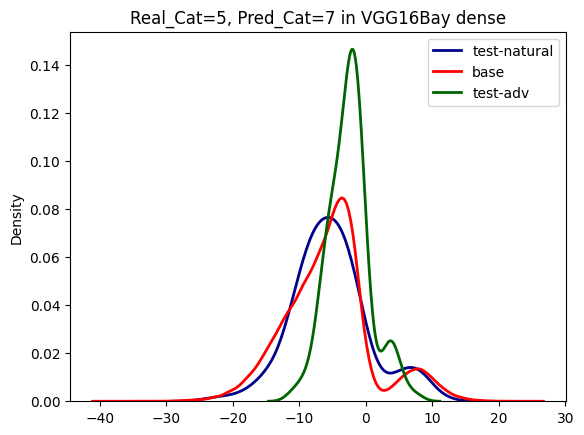

In [664]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


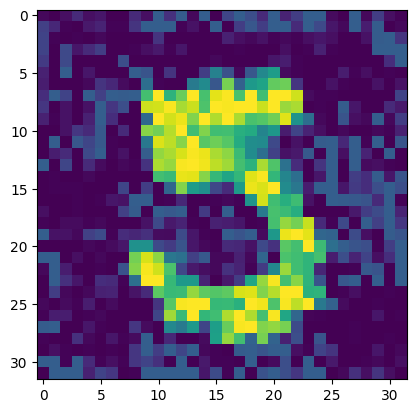

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[7]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

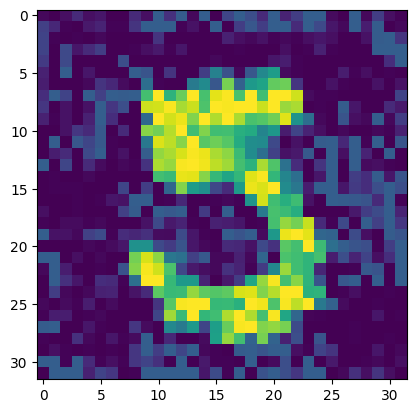

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.443168221520526
distancia det energia distribucion base y el ejemplo natural  1.26222517491751


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.443168221520526
distancia energia distribucion base y el ejemplo adversario  1.26222517491751


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1726-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1726-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

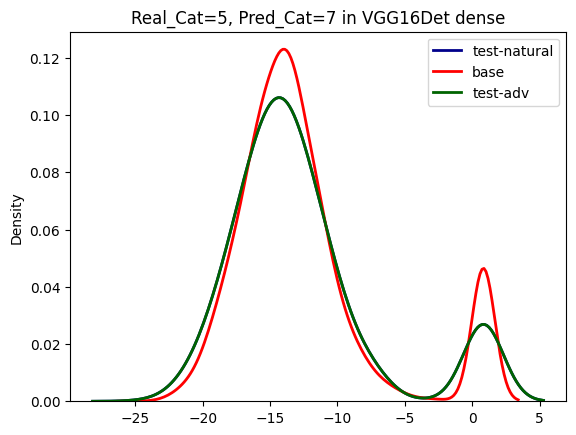

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


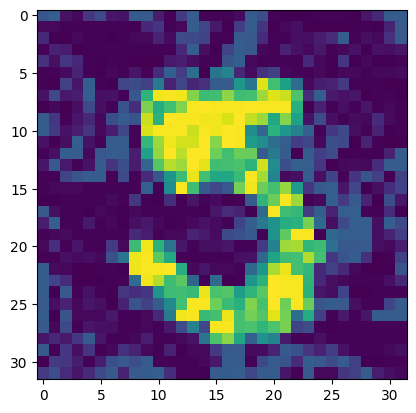

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

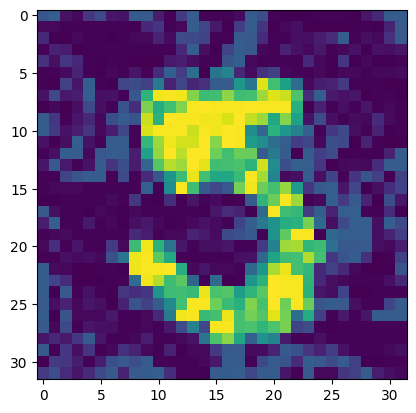

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.4212880430392194
distancia energia distribucion base y el ejemplo natural  0.8904439274873974


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.6068567642138976
distancia energia distribucion base y el ejemplo adversario  1.1557132219958164


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1741-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1741-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

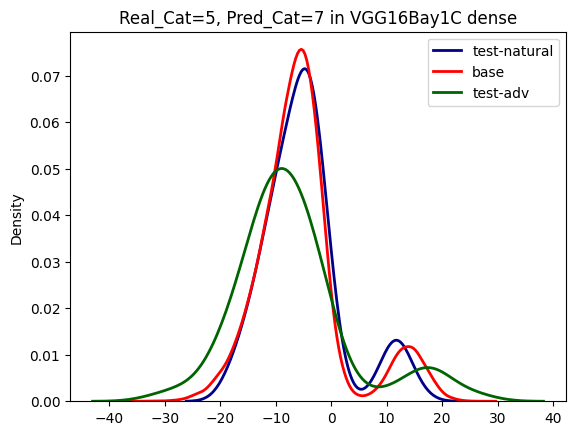

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [665]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [666]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [667]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [668]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 284ms/step - loss: -1.0572 - accuracy: 0.9940


[-1.0571935176849365, 0.9939903616905212]

In [669]:
vgg_det_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 71ms/step - loss: 0.0141 - accuracy: 0.9976


[0.014121459797024727, 0.9975961446762085]

In [670]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 77ms/step - loss: -1.0634 - accuracy: 0.9964


[-1.0634232759475708, 0.9963942170143127]

### 100 Bayesiano

In [671]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [672]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [673]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [674]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [675]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [676]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  5


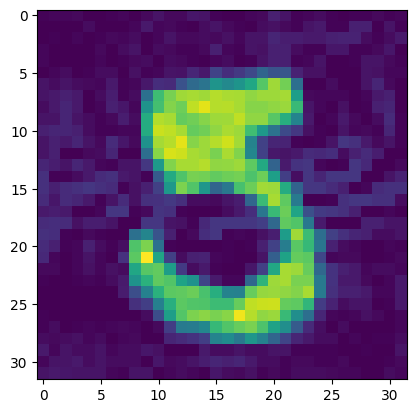

In [677]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [678]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [679]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [680]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [681]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.433180797108395
distancia energia distribucion base y el ejemplo natural  1.4960081341496025


In [682]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [683]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.847829204469306
distancia energia distribucion base y el ejemplo adversario  2.334253785345311


In [684]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-685-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-685-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

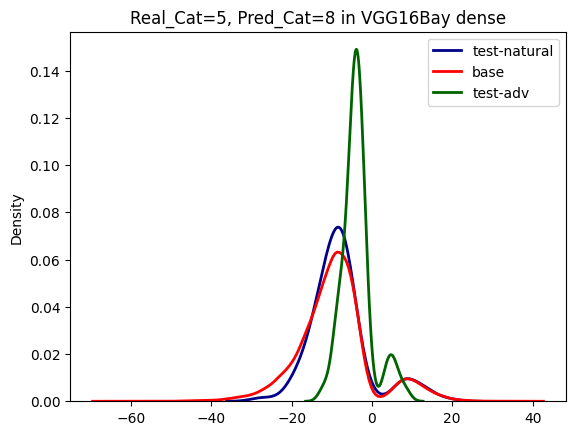

In [685]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


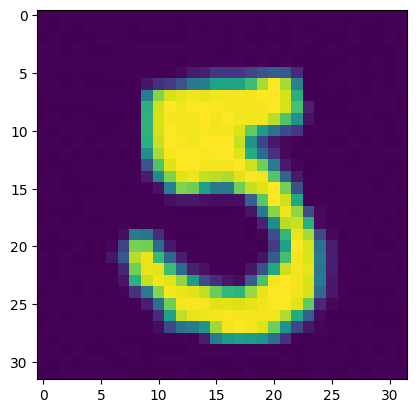

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[5]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

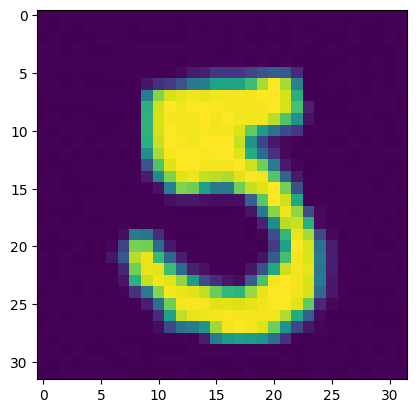

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.7088734540996553
distancia det energia distribucion base y el ejemplo natural  1.469860262029595


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7088734540996553
distancia energia distribucion base y el ejemplo adversario  1.469860262029595


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-3619-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-3619-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

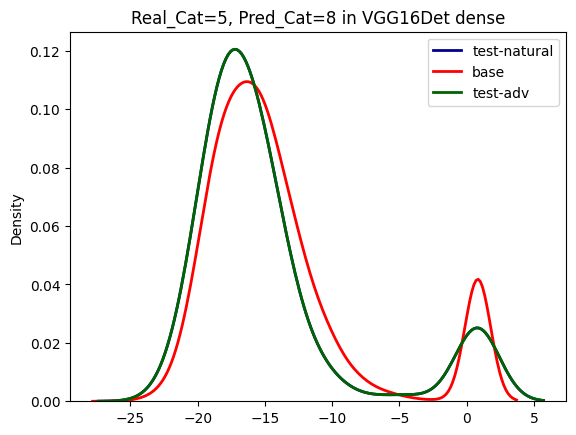

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


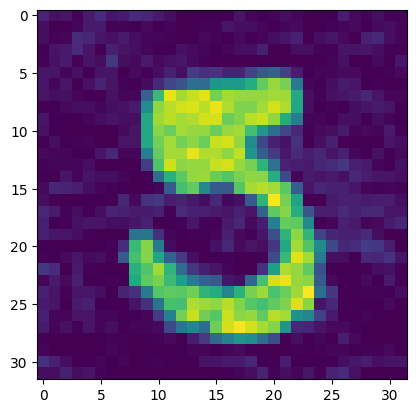

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

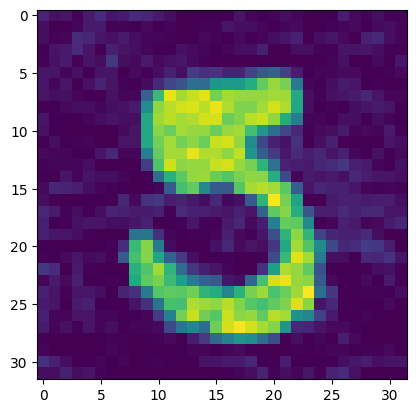

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6385538280894796
distancia energia distribucion base y el ejemplo natural  0.9810307298664


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.31042376619427
distancia energia distribucion base y el ejemplo adversario  1.8515816148835365


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-3634-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-3634-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

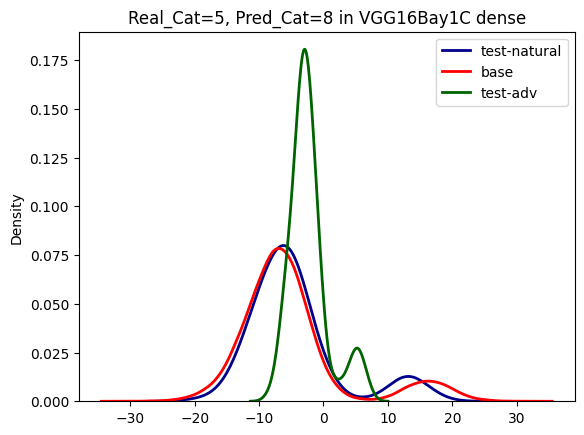

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [686]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [687]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [688]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [689]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 3s 203ms/step - loss: -1.0467 - accuracy: 0.9877


[-1.0467449426651, 0.9877232313156128]

In [690]:
vgg_det_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 72ms/step - loss: 0.0207 - accuracy: 0.9922


[0.02072400227189064, 0.9921875]

In [691]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 84ms/step - loss: -1.0029 - accuracy: 0.9866


[-1.0029250383377075, 0.9866071343421936]

### 100 Bayesiano

In [692]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [693]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [694]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [695]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [696]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [697]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  5


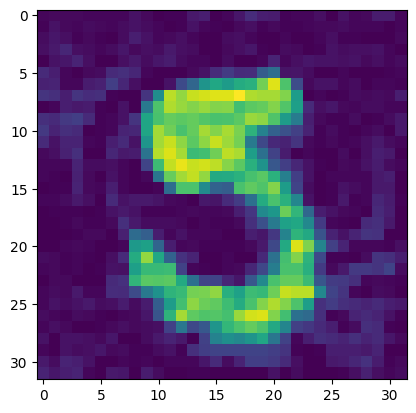

In [698]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [699]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [700]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [701]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [702]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.6087972404050106
distancia energia distribucion base y el ejemplo natural  1.2420903033933266


In [703]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [704]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.724591763891779
distancia energia distribucion base y el ejemplo adversario  1.6561756196497068


In [705]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-706-ab76e7dbdafc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-706-ab76e7dbdafc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

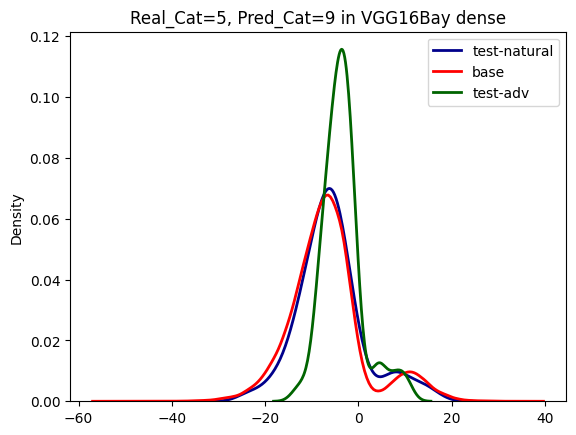

In [706]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### Determinista

In [ ]:
dict_vggdetmnist=get_layer_dictionary(vgg_det_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense


In [ ]:
import keras.backend as K
import math

def inv_softmax(x,C):
   return K.log(x)+K.log(C)

valued_list=[]
for datadx, datady in train_ds_tf:
    for _ in range(1):
        predictdx=dict_vggdetmnist[Cap](datadx)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list.append(valued)
valued_list= np.concatenate(valued_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list)

In [ ]:
valued_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(1):
        predictx=dict_vggdetmnist[Cap](dataxtest1)
        xrd=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valued=xrd
        valued_list_test.append(valued)
valued_list_test= np.concatenate(valued_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_test)

el label verdadero es:  5


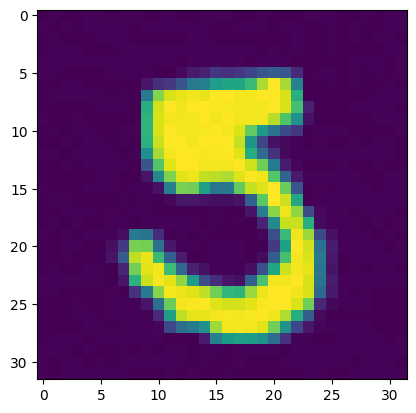

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack_soft(dict_vggdetmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
### aqui no usamos loop xq es determinista!
print(tf.argmax(vgg_det_mnist(img_adv[None,...]),axis=-1).numpy())

[5]


In [ ]:
valued_list_testadv=[]
for _ in range(1):
        predictx=dict_vggdetmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.Lambda(lambda x : inv_softmax(x, math.log(10.)),name='inv_softmax')(predictdx)
        valud=xr
        valued_list_testadv.append(valued)
valued_list_testadv= np.concatenate(valued_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valued_list_testadv)

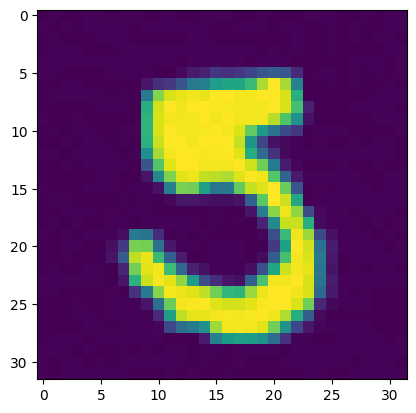

In [ ]:
plt.imshow(img_adv)

In [ ]:
distribuciondet_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valuedet_list.npy'))
ejemplodet_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valuedet_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplodet_natural:
    for idx in distribuciondet_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia det wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia det energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia det wasserstein distribucion base y el ejemplo natural  2.8093051769907893
distancia det energia distribucion base y el ejemplo natural  1.3047930919226882


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplodet_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valued_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplodet_adversario:
    for idx in distribuciondet_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.8093051769907893
distancia energia distribucion base y el ejemplo adversario  1.3047930919226882


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-3670-d711746d5cb8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-3670-d711746d5cb8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(

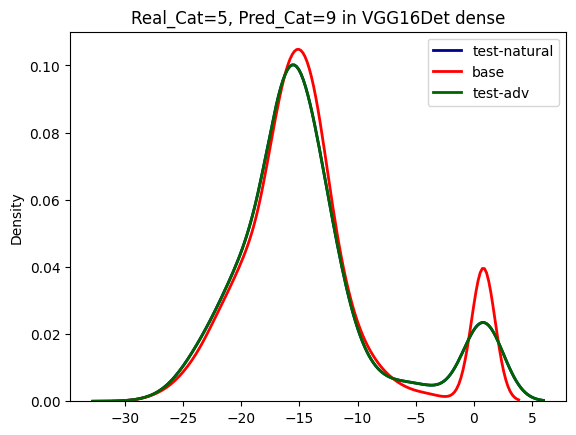

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'Det',Cap,Att,Epx,DS,Cat,Vic,'Det')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplodet_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribuciondet_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplodet_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Det', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_2
1 flatten_2
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [ ]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  5


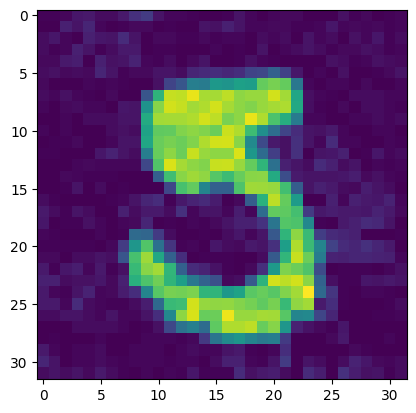

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

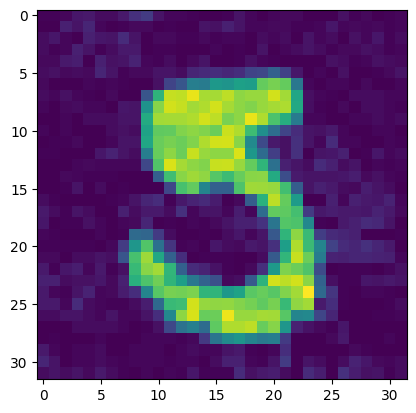

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.210552577616697
distancia energia distribucion base y el ejemplo natural  1.0713675940948775


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.837834909844338
distancia energia distribucion base y el ejemplo adversario  1.905769322652448


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-3685-29f7d6f51a8e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-3685-29f7d6f51a8e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(d

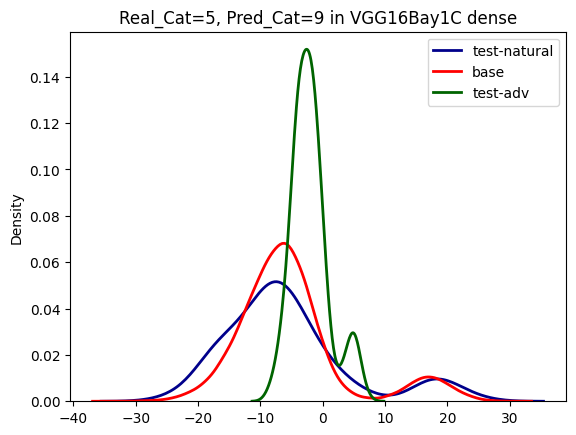

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1C',Cap,Att,Epx,DS,Cat,Vic,'1C')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)